In [1]:
import os
import torch
from tqdm import tqdm
import numpy as np
import io

import matplotlib.pyplot as plt
from utils import setup_seed
from dataset import Kitti, get_dataloader
from model import PointPillars
from loss import Loss
from tensorboardX import SummaryWriter
import cv2
import io


import argparse
import os
import torch
from tqdm import tqdm
import pdb
import numpy as np

import matplotlib.pyplot as plt
from utils import setup_seed, keep_bbox_from_image_range, \
    keep_bbox_from_lidar_range, write_pickle, write_label, \
    iou2d, iou3d_camera, iou_bev
from dataset import Kitti, get_dataloader
from model import PointPillars
from loss import Loss


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Function to plot the scalars and convert the plot to a tensor image
def plot_scalars(scalars, step):
    fig, ax = plt.subplots()
    ax.plot(scalars)
    ax.set_title(f'Step {step}')
    ax.set_xlabel('Scalar Index')
    ax.set_ylabel('Value')
    plt.grid(True)

    # Convert the plot to a PNG image
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)

    # Convert PNG buffer to a tensor image
    image = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)  # Decode the image
    image = torch.from_numpy(image).permute(2, 0, 1)#.unsqueeze(0)  # Convert to PyTorch tensor and add batch dimension
    return image

def save_summary(writer, loss_dict, global_step, tag, gating_prob, lr=None, momentum=None, model=None, data=None, flag=False):
    for k, v in loss_dict.items():
        writer.add_scalar(f'{tag}/{k}', v, global_step)
    if lr is not None:
        writer.add_scalar('lr', lr, global_step)
    if momentum is not None:
        writer.add_scalar('momentum', momentum, global_step)
    if model is not None and global_step % 1000 == 0:
        for tag, value in model.named_parameters():
            # import pdb
            # pdb.set_trace()
            if value.grad is not None:
                writer.add_histogram(tag + "/grad", value.grad.cpu(), global_step)
    
    if global_step % 100 == 0:
        image = plot_scalars(gating_prob.detach().cpu().numpy(), global_step)
        writer.add_image("Scalars Plot", image, global_step=global_step)
    # for i in data:
    #     del i['gt_names']
    #     del i['image_info']
    #     del i['calib_info']
    #     del i['difficulty']

    # writer.add_graph(model, data)



### Training Arguments

In [3]:
class Args:
    def __init__(self):
        self.data_root = "dataset/KITTI"
        self.saved_path = "logs/pillar_sequence_mem_lin_gat_8_masking_pruning"
        self.saved_path_exact = self.saved_path + "/results_exact"
        self.saved_path_estimate = self.saved_path + "/results_estimate"
        self.batch_size = 4
        self.num_workers = 4
        self.window_length = 1
        self.nclasses = 3
        self.init_lr = 0.00025
        self.max_epoch = 200
        self.log_freq = 1        
        self.ckpt_freq_epoch = 2
        self.val_freq_epoch = 5
        self.no_cuda = not torch.cuda.is_available()
 
args = Args()

### Dataloader

In [4]:
train_dataset = Kitti(data_root=args.data_root,
                        split='train')
val_dataset = Kitti(data_root=args.data_root,
                    split='val')
train_dataloader = get_dataloader(dataset=train_dataset, 
                                    batch_size=args.batch_size, 
                                    num_workers=args.num_workers,
                                    shuffle=True)
val_dataloader = get_dataloader(dataset=val_dataset, 
                                batch_size=args.batch_size, 
                                num_workers=args.num_workers,
                                shuffle=False)

# data = train_dataset.__getitem__(9)

train_dataset_length = len(train_dataset.sorted_ids)
train_dataset_batch_count =  train_dataset_length 
val_dataset_length = len(val_dataset.sorted_ids)

def get_sequence_from_velodyne_path(file_path):
    parts = file_path.split('/')
    file_name = parts[-1]
    extracted_part = file_name.split('_')[0]
    return extracted_part

# Print the extracted part

CLASSES = Kitti.CLASSES
LABEL2CLASSES = {v:k for k, v in CLASSES.items()}


pcd_limit_range = np.array([0, -40, -3, 70.4, 40, 0.0], dtype=np.float32)


### Model, Loss, Optimizer, Scheduler, Log

In [5]:
if not args.no_cuda:
    pointpillars = PointPillars(nclasses=args.nclasses).cuda()
else:
    pointpillars = PointPillars(nclasses=args.nclasses)

model_flag = False

loss_func = Loss()

max_iters = 2* train_dataset_batch_count * args.max_epoch
init_lr = args.init_lr
optimizer = torch.optim.AdamW(params=pointpillars.parameters(), 
                                lr=init_lr, 
                                betas=(0.95, 0.99),
                                weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,  
                                                max_lr=init_lr*10, 
                                                total_steps=max_iters, 
                                                pct_start=0.4, 
                                                anneal_strategy='cos',
                                                cycle_momentum=True, 
                                                base_momentum=0.95*0.895, 
                                                max_momentum=0.95,
                                                div_factor=10)


saved_logs_path = os.path.join(args.saved_path, 'summary')
import shutil
if os.path.exists(saved_logs_path):
    shutil.rmtree(saved_logs_path)
os.makedirs(saved_logs_path, exist_ok=True)
writer = SummaryWriter(saved_logs_path)
saved_ckpt_path = os.path.join(args.saved_path, 'checkpoints')
os.makedirs(saved_ckpt_path, exist_ok=True)

# Directory for exact results
saved_path_exact = args.saved_path_exact
os.makedirs(saved_path_exact, exist_ok=True)
saved_submit_path_exact = os.path.join(saved_path_exact, 'submit')
os.makedirs(saved_submit_path_exact, exist_ok=True)

# Directory for estimate results
saved_path_estimate = args.saved_path_estimate
os.makedirs(saved_path_estimate, exist_ok=True)
saved_submit_path_estimate = os.path.join(saved_path_estimate, 'submit')
os.makedirs(saved_submit_path_estimate, exist_ok=True)


### Validation Stuff

In [6]:
def get_score_thresholds(tp_scores, total_num_valid_gt, num_sample_pts=41):
    score_thresholds = []
    tp_scores = sorted(tp_scores)[::-1]
    cur_recall, pts_ind = 0, 0
    for i, score in enumerate(tp_scores):
        lrecall = (i + 1) / total_num_valid_gt
        rrecall = (i + 2) / total_num_valid_gt

        if i == len(tp_scores) - 1:
            score_thresholds.append(score)
            break

        if (lrecall + rrecall) / 2 < cur_recall:
            continue

        score_thresholds.append(score)
        pts_ind += 1
        cur_recall = pts_ind / (num_sample_pts - 1)
    return score_thresholds

In [7]:
def do_eval(det_results, gt_results, CLASSES, saved_path):
    '''
    det_results: list,
    gt_results: dict(id -> det_results)
    CLASSES: dict
    '''
    assert len(det_results) == len(gt_results)
    f = open(os.path.join(saved_path, 'eval_results.txt'), 'w')

    # 1. calculate iou
    ious = {
        'bbox_2d': [],
        'bbox_bev': [],
        'bbox_3d': []
    }
    ids = list(sorted(gt_results.keys()))
    for id in ids:
        gt_result = gt_results[id]['annos']
        det_result = det_results[id]

        # 1.1, 2d bboxes iou
        gt_bboxes2d = gt_result['bbox'].astype(np.float32)
        det_bboxes2d = det_result['bbox'].astype(np.float32)
        iou2d_v = iou2d(torch.from_numpy(gt_bboxes2d).cuda(), torch.from_numpy(det_bboxes2d).cuda())
        ious['bbox_2d'].append(iou2d_v.cpu().numpy())

        # 1.2, bev iou
        gt_location = gt_result['location'].astype(np.float32)
        gt_dimensions = gt_result['dimensions'].astype(np.float32)
        gt_rotation_y = gt_result['rotation_y'].astype(np.float32)
        det_location = det_result['location'].astype(np.float32)
        det_dimensions = det_result['dimensions'].astype(np.float32)
        det_rotation_y = det_result['rotation_y'].astype(np.float32)

        gt_bev = np.concatenate([gt_location[:, [0, 2]], gt_dimensions[:, [0, 2]], gt_rotation_y[:, None]], axis=-1)
        det_bev = np.concatenate([det_location[:, [0, 2]], det_dimensions[:, [0, 2]], det_rotation_y[:, None]], axis=-1)
        iou_bev_v = iou_bev(torch.from_numpy(gt_bev).cuda(), torch.from_numpy(det_bev).cuda())
        ious['bbox_bev'].append(iou_bev_v.cpu().numpy())

        # 1.3, 3dbboxes iou
        gt_bboxes3d = np.concatenate([gt_location, gt_dimensions, gt_rotation_y[:, None]], axis=-1)
        det_bboxes3d = np.concatenate([det_location, det_dimensions, det_rotation_y[:, None]], axis=-1)
        iou3d_v = iou3d_camera(torch.from_numpy(gt_bboxes3d).cuda(), torch.from_numpy(det_bboxes3d).cuda())
        ious['bbox_3d'].append(iou3d_v.cpu().numpy())

    MIN_IOUS = {
        'Pedestrian': [0.5, 0.5, 0.5],
        'Cyclist': [0.5, 0.5, 0.5],
        'Car': [0.7, 0.7, 0.7]
    }
    MIN_HEIGHT = [40, 25, 25]

    overall_results = {}
    for e_ind, eval_type in enumerate(['bbox_2d', 'bbox_bev', 'bbox_3d']):
        eval_ious = ious[eval_type]
        eval_ap_results, eval_aos_results = {}, {}
        for cls in CLASSES:
            eval_ap_results[cls] = []
            eval_aos_results[cls] = []
            CLS_MIN_IOU = MIN_IOUS[cls][e_ind]
            for difficulty in [0, 1, 2]:
                # 1. bbox property
                total_gt_ignores, total_det_ignores, total_dc_bboxes, total_scores = [], [], [], []
                total_gt_alpha, total_det_alpha = [], []
                for id in ids:
                    gt_result = gt_results[id]['annos']
                    det_result = det_results[id]

                    # 1.1 gt bbox property
                    cur_gt_names = gt_result['name']
                    cur_difficulty = gt_result['difficulty']
                    gt_ignores, dc_bboxes = [], []
                    for j, cur_gt_name in enumerate(cur_gt_names):
                        ignore = cur_difficulty[j] < 0 or cur_difficulty[j] > difficulty
                        if cur_gt_name == cls:
                            valid_class = 1
                        elif cls == 'Pedestrian' and cur_gt_name == 'Person_sitting':
                            valid_class = 0
                        elif cls == 'Car' and cur_gt_name == 'Van':
                            valid_class = 0
                        else:
                            valid_class = -1
                        
                        if valid_class == 1 and not ignore:
                            gt_ignores.append(0)
                        elif valid_class == 0 or (valid_class == 1 and ignore):
                            gt_ignores.append(1)
                        else:
                            gt_ignores.append(-1)
                        
                        if cur_gt_name == 'DontCare':
                            dc_bboxes.append(gt_result['bbox'][j])
                    total_gt_ignores.append(gt_ignores)
                    total_dc_bboxes.append(np.array(dc_bboxes))
                    total_gt_alpha.append(gt_result['alpha'])

                    # 1.2 det bbox property
                    cur_det_names = det_result['name']
                    cur_det_heights = det_result['bbox'][:, 3] - det_result['bbox'][:, 1]
                    det_ignores = []
                    for j, cur_det_name in enumerate(cur_det_names):
                        if cur_det_heights[j] < MIN_HEIGHT[difficulty]:
                            det_ignores.append(1)
                        elif cur_det_name == cls:
                            det_ignores.append(0)
                        else:
                            det_ignores.append(-1)
                    total_det_ignores.append(det_ignores)
                    total_scores.append(det_result['score'])
                    total_det_alpha.append(det_result['alpha'])

                # 2. calculate scores thresholds for PR curve
                tp_scores = []
                for i, id in enumerate(ids):
                    cur_eval_ious = eval_ious[i]
                    gt_ignores, det_ignores = total_gt_ignores[i], total_det_ignores[i]
                    scores = total_scores[i]

                    nn, mm = cur_eval_ious.shape
                    assigned = np.zeros((mm, ), dtype=np.bool_)
                    for j in range(nn):
                        if gt_ignores[j] == -1:
                            continue
                        match_id, match_score = -1, -1
                        for k in range(mm):
                            if not assigned[k] and det_ignores[k] >= 0 and cur_eval_ious[j, k] > CLS_MIN_IOU and scores[k] > match_score:
                                match_id = k
                                match_score = scores[k]
                        if match_id != -1:
                            assigned[match_id] = True
                            if det_ignores[match_id] == 0 and gt_ignores[j] == 0:
                                tp_scores.append(match_score)
                total_num_valid_gt = np.sum([np.sum(np.array(gt_ignores) == 0) for gt_ignores in total_gt_ignores])
                score_thresholds = get_score_thresholds(tp_scores, total_num_valid_gt)    
            
                # 3. draw PR curve and calculate mAP
                tps, fns, fps, total_aos = [], [], [], []

                for score_threshold in score_thresholds:
                    tp, fn, fp = 0, 0, 0
                    aos = 0
                    for i, id in enumerate(ids):
                        cur_eval_ious = eval_ious[i]
                        gt_ignores, det_ignores = total_gt_ignores[i], total_det_ignores[i]
                        gt_alpha, det_alpha = total_gt_alpha[i], total_det_alpha[i]
                        scores = total_scores[i]

                        nn, mm = cur_eval_ious.shape
                        assigned = np.zeros((mm, ), dtype=np.bool_)
                        for j in range(nn):
                            if gt_ignores[j] == -1:
                                continue
                            match_id, match_iou = -1, -1
                            for k in range(mm):
                                if not assigned[k] and det_ignores[k] >= 0 and scores[k] >= score_threshold and cur_eval_ious[j, k] > CLS_MIN_IOU:
    
                                    if det_ignores[k] == 0 and cur_eval_ious[j, k] > match_iou:
                                        match_iou = cur_eval_ious[j, k]
                                        match_id = k
                                    elif det_ignores[k] == 1 and match_iou == -1:
                                        match_id = k

                            if match_id != -1:
                                assigned[match_id] = True
                                if det_ignores[match_id] == 0 and gt_ignores[j] == 0:
                                    tp += 1
                                    if eval_type == 'bbox_2d':
                                        aos += (1 + np.cos(gt_alpha[j] - det_alpha[match_id])) / 2
                            else:
                                if gt_ignores[j] == 0:
                                    fn += 1
                            
                        for k in range(mm):
                            if det_ignores[k] == 0 and scores[k] >= score_threshold and not assigned[k]:
                                fp += 1
                        
                        # In case 2d bbox evaluation, we should consider dontcare bboxes
                        if eval_type == 'bbox_2d':
                            dc_bboxes = total_dc_bboxes[i]
                            det_bboxes = det_results[id]['bbox']
                            if len(dc_bboxes) > 0:
                                ious_dc_det = iou2d(torch.from_numpy(det_bboxes), torch.from_numpy(dc_bboxes), metric=1).numpy().T
                                for j in range(len(dc_bboxes)):
                                    for k in range(len(det_bboxes)):
                                        if det_ignores[k] == 0 and scores[k] >= score_threshold and not assigned[k]:
                                            if ious_dc_det[j, k] > CLS_MIN_IOU:
                                                fp -= 1
                                                assigned[k] = True
                            
                    tps.append(tp)
                    fns.append(fn)
                    fps.append(fp)
                    if eval_type == 'bbox_2d':
                        total_aos.append(aos)

                tps, fns, fps = np.array(tps), np.array(fns), np.array(fps)

                precisions = tps / (tps + fns) # actually this is recalls
                # precisions = tps / (tps + fps)
                for i in range(len(score_thresholds)):
                    precisions[i] = np.max(precisions[i:])
                
                sums_AP = 0
                for i in range(0, len(score_thresholds), 4):
                    sums_AP += precisions[i]
                mAP = sums_AP / 11 * 100
                eval_ap_results[cls].append(mAP)

                if eval_type == 'bbox_2d':
                    total_aos = np.array(total_aos)
                    similarity = total_aos / (tps + fps)
                    for i in range(len(score_thresholds)):
                        similarity[i] = np.max(similarity[i:])
                    sums_similarity = 0
                    for i in range(0, len(score_thresholds), 4):
                        sums_similarity += similarity[i]
                    mSimilarity = sums_similarity / 11 * 100
                    eval_aos_results[cls].append(mSimilarity)

        print(f'=========={eval_type.upper()}==========')
        print(f'=========={eval_type.upper()}==========', file=f)
        for k, v in eval_ap_results.items():
            print(f'{k} AP@{MIN_IOUS[k][e_ind]}: {v[0]:.4f} {v[1]:.4f} {v[2]:.4f}')
            print(f'{k} AP@{MIN_IOUS[k][e_ind]}: {v[0]:.4f} {v[1]:.4f} {v[2]:.4f}', file=f)
        if eval_type == 'bbox_2d':
            print(f'==========AOS==========')
            print(f'==========AOS==========', file=f)
            for k, v in eval_aos_results.items():
                print(f'{k} AOS@{MIN_IOUS[k][e_ind]}: {v[0]:.4f} {v[1]:.4f} {v[2]:.4f}')
                print(f'{k} AOS@{MIN_IOUS[k][e_ind]}: {v[0]:.4f} {v[1]:.4f} {v[2]:.4f}', file=f)
        
        overall_results[eval_type] = np.mean(list(eval_ap_results.values()), 0)
        if eval_type == 'bbox_2d':
            overall_results['AOS'] = np.mean(list(eval_aos_results.values()), 0)
    
    print(f'\n==========Overall==========')
    print(f'\n==========Overall==========', file=f)
    for k, v in overall_results.items():
        print(f'{k} AP: {v[0]:.4f} {v[1]:.4f} {v[2]:.4f}')
        print(f'{k} AP: {v[0]:.4f} {v[1]:.4f} {v[2]:.4f}', file=f)
    f.close()

### Training

In [8]:
def measure_losses(bbox_cls_pred0, bbox_pred0, bbox_dir_cls_pred0, anchor_target_dict):
    
    ################# Full features #################
    bbox_cls_pred0 = bbox_cls_pred0.permute(0, 2, 3, 1).reshape(-1, args.nclasses)
    bbox_pred0 = bbox_pred0.permute(0, 2, 3, 1).reshape(-1, 7)
    bbox_dir_cls_pred0 = bbox_dir_cls_pred0.permute(0, 2, 3, 1).reshape(-1, 2)

    batched_bbox_labels = anchor_target_dict['batched_labels'].reshape(-1)
    batched_label_weights = anchor_target_dict['batched_label_weights'].reshape(-1)
    batched_bbox_reg = anchor_target_dict['batched_bbox_reg'].reshape(-1, 7)
    batched_dir_labels = anchor_target_dict['batched_dir_labels'].reshape(-1)

    pos_idx = (batched_bbox_labels >= 0) & (batched_bbox_labels < args.nclasses)

    bbox_pred0 = bbox_pred0[pos_idx]
    batched_bbox_reg = batched_bbox_reg[pos_idx]
    batched_bbox_reg0 = batched_bbox_reg.clone()

    # sin(a - b) = sin(a)*cos(b) - cos(a)*sin(b)
    bbox_pred0[:, -1] = torch.sin(bbox_pred0[:, -1].clone()) * torch.cos(batched_bbox_reg[:, -1].clone())
    batched_bbox_reg0[:, -1] = torch.cos(bbox_pred0[:, -1].clone()) * torch.sin(batched_bbox_reg[:, -1].clone())
    bbox_dir_cls_pred0 = bbox_dir_cls_pred0[pos_idx]
    batched_dir_labels = batched_dir_labels[pos_idx]
    num_cls_pos = (batched_bbox_labels < args.nclasses).sum()
    bbox_cls_pred0 = bbox_cls_pred0[batched_label_weights > 0]


    batched_bbox_labels[batched_bbox_labels < 0] = args.nclasses
    batched_bbox_labels = batched_bbox_labels[batched_label_weights > 0]

    loss_dict0 = loss_func(bbox_cls_pred=bbox_cls_pred0,
                            bbox_pred=bbox_pred0,
                            bbox_dir_cls_pred=bbox_dir_cls_pred0,
                            batched_labels=batched_bbox_labels, 
                            num_cls_pos=num_cls_pos, 
                            batched_bbox_reg=batched_bbox_reg0, 
                            batched_dir_labels=batched_dir_labels)

    # gLoss = torch.sum(p*torch.norm(y-ye, dim=(1,2,3)))
    # l2 norm
    # gLoss = (((1-g)*(y-ye)).pow(2).sum(dim=(1,2,3)).pow(0.5)).sum()

    return loss_dict0

In [9]:
# # pointpillars.load_state_dict(torch.load("logs/pillar_sequence_memory_gating_binary/checkpoints/epoch_60.pth"))
# checkpoint = torch.load("logs/pillar_sequence_mem_lin_gat_7_optical_flow/checkpoints/epoch_99.pth.tar")
# pointpillars.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch0 = checkpoint['epoch']
# loss = checkpoint['loss']

# training_loss0 = np.load("logs/pillar_sequence_memory_linearization/checkpoints/train_loss.npy").tolist()
# training_gLoss0 = np.load("logs/pillar_sequence_memory_linearization/checkpoints/train_gloss.npy").tolist()
# val_loss0 = np.load("logs/pillar_sequence_memory_linearization/checkpoints/val_loss.npy").tolist()
# val_gLoss0 = np.load("logs/pillar_sequence_memory_linearization/checkpoints/val_gloss.npy").tolist()

training_loss0 = []
training_gLoss0 = []


In [10]:
def regularize(model, lambd = 1.01):

    A = model.pillar_encoder.global_masks[0]
    # B = torch.tensor([lambd ** i for i in range(len(A))], dtype=torch.float32).unsqueeze(0).to(A.device)
    _, indices = torch.sort(A, dim=1, descending=True)
    B = torch.pow(lambd, indices)
    regularized_loss = torch.sum(A * B)


    A = model.neck.global_masks[0]
    _, indices = torch.sort(A, dim=1, descending=True)
    B = torch.pow(lambd, indices)
    regularized_loss += torch.sum(A * B)


    for A in model.backbone.global_masks:
        _, indices = torch.sort(A, dim=1, descending=True)
        B = torch.pow(lambd, indices)
        regularized_loss += torch.sum(A * B)


    return regularized_loss

# def regularize2(model, lambd = 1.1):

#     A = model.pillar_encoder.global_masks[0]
#     B = torch.tensor([lambd ** i for i in range(A.shape[1])], dtype=torch.float32).unsqueeze(0).to(A.device)
#     A_sorted, indices = torch.sort(A, descending=True)
#     regularized_loss = torch.sum(A_sorted * B)

#     A = model.neck.global_masks[0]
#     B = torch.tensor([lambd ** i for i in range(A.shape[1])], dtype=torch.float32).unsqueeze(0).to(A.device)
#     A_sorted, indices = torch.sort(A, descending=True)
#     regularized_loss += torch.sum(A_sorted * B)


#     for A in model.backbone.global_masks:
#         B = torch.tensor([lambd ** i for i in range(A.shape[1])], dtype=torch.float32).unsqueeze(0).to(A.device)
#         A_sorted, indices = torch.sort(A, descending=True)
#         regularized_loss += torch.sum(A_sorted * B)


#     return regularized_loss



==================== 0 ====================


100%|██████████| 1317/1317 [09:09<00:00,  2.40it/s]


==================== 1 ====================


100%|██████████| 1317/1317 [09:16<00:00,  2.37it/s]


==================== 2 ====================


100%|██████████| 1317/1317 [09:19<00:00,  2.35it/s]


==================== 3 ====================


100%|██████████| 1317/1317 [09:16<00:00,  2.37it/s]


==================== 4 ====================


100%|██████████| 1317/1317 [09:16<00:00,  2.37it/s]


==================== 5 ====================


100%|██████████| 1317/1317 [09:15<00:00,  2.37it/s]


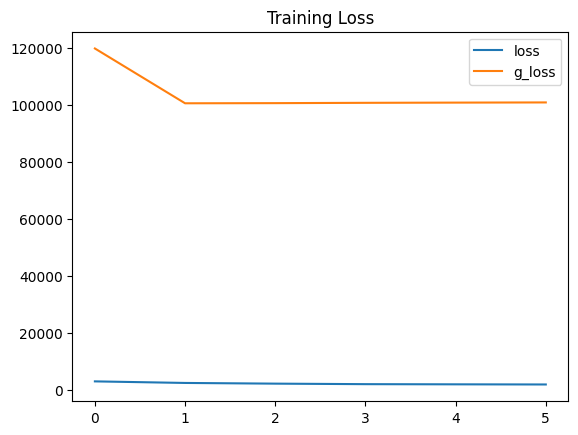

Predicting and Formatting the results.


100%|██████████| 217/217 [00:40<00:00,  5.38it/s]


Evaluating.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 10.1732 7.2356 7.2356
Cyclist AP@0.5: 15.9091 42.7033 42.7033
Car AP@0.7: 51.8452 27.9063 26.7363
==========AOS==========
Pedestrian AOS@0.5: 7.9469 7.4604 7.4604
Cyclist AOS@0.5: 10.9037 13.3576 13.3576
Car AOS@0.7: 45.2835 31.4919 29.7022
==========BBOX_BEV==========
Pedestrian AP@0.5: 11.0390 10.3896 10.3896
Cyclist AP@0.5: 15.9091 2.1531 2.1531
Car AP@0.7: 19.8864 12.6294 11.7178
==========BBOX_3D==========
Pedestrian AP@0.5: 2.5974 2.4119 2.4119
Cyclist AP@0.5: 1.1364 0.3589 0.3589
Car AP@0.7: 5.4868 2.5753 2.3564

==========Overall==========
bbox_2d AP: 25.9758 25.9484 25.5584
AOS AP: 21.3780 17.4366 16.8401
bbox_bev AP: 15.6115 8.3907 8.0868
bbox_3d AP: 3.0735 1.7820 1.7090
==================== 6 ====================


100%|██████████| 1317/1317 [09:16<00:00,  2.37it/s]


==================== 7 ====================


100%|██████████| 1317/1317 [09:13<00:00,  2.38it/s]


==================== 8 ====================


100%|██████████| 1317/1317 [09:16<00:00,  2.37it/s]


==================== 9 ====================


100%|██████████| 1317/1317 [09:15<00:00,  2.37it/s]


==================== 10 ====================


100%|██████████| 1317/1317 [09:13<00:00,  2.38it/s]


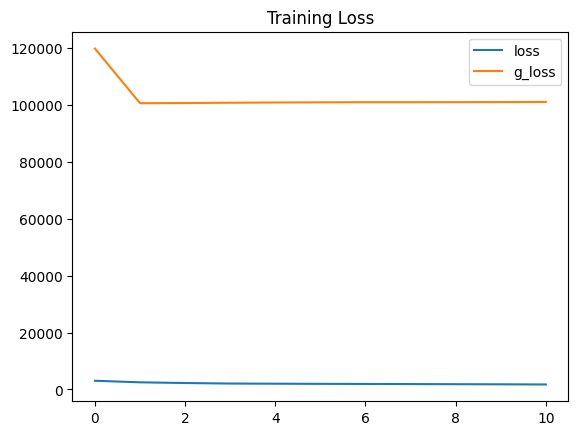

Predicting and Formatting the results.


100%|██████████| 217/217 [00:39<00:00,  5.43it/s]


Evaluating.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 54.1126 41.5584 41.5584
Cyclist AP@0.5: 15.9091 30.8612 30.8612
Car AP@0.7: 36.7495 19.0682 18.2552
==========AOS==========
Pedestrian AOS@0.5: 10.4076 9.2411 9.2411
Cyclist AOS@0.5: 1.9669 3.3422 3.3422
Car AOS@0.7: 39.1400 27.6750 24.9249
==========BBOX_BEV==========
Pedestrian AP@0.5: 12.1212 11.3173 11.3173
Cyclist AP@0.5: 11.3636 2.8708 2.8708
Car AP@0.7: 10.7015 5.7790 5.1712
==========BBOX_3D==========
Pedestrian AP@0.5: 2.8139 2.4119 2.4119
Cyclist AP@0.5: 0.0000 0.0000 0.0000
Car AP@0.7: 2.4517 1.6070 1.4303

==========Overall==========
bbox_2d AP: 35.5904 30.4960 30.2250
AOS AP: 17.1715 13.4194 12.5027
bbox_bev AP: 11.3955 6.6557 6.4531
bbox_3d AP: 1.7552 1.3396 1.2807
==================== 11 ====================


100%|██████████| 1317/1317 [09:15<00:00,  2.37it/s]


==================== 12 ====================


100%|██████████| 1317/1317 [09:10<00:00,  2.39it/s]


==================== 13 ====================


100%|██████████| 1317/1317 [09:14<00:00,  2.38it/s]


==================== 14 ====================


100%|██████████| 1317/1317 [09:10<00:00,  2.39it/s]


==================== 15 ====================


100%|██████████| 1317/1317 [09:14<00:00,  2.38it/s]


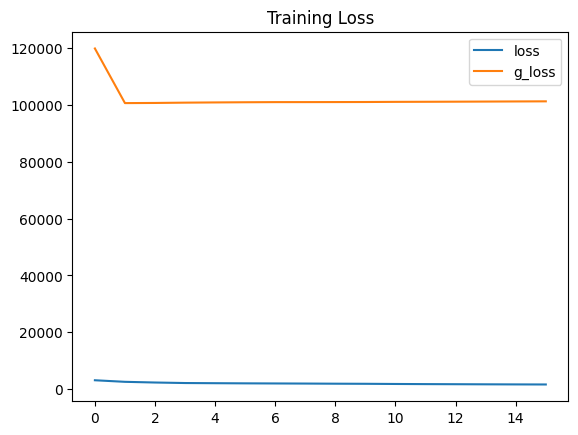

Predicting and Formatting the results.


100%|██████████| 217/217 [00:39<00:00,  5.43it/s]


Evaluating.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 2.5974 2.4119 2.4119
Cyclist AP@0.5: 18.1818 54.5455 54.5455
Car AP@0.7: 55.2000 31.0585 29.3495
==========AOS==========
Pedestrian AOS@0.5: 0.8373 0.8077 0.8077
Cyclist AOS@0.5: 9.4453 13.7122 13.7122
Car AOS@0.7: 52.3218 39.4668 38.3588
==========BBOX_BEV==========
Pedestrian AP@0.5: 50.2165 39.6104 39.6104
Cyclist AP@0.5: 18.1818 2.8708 2.8708
Car AP@0.7: 37.7881 25.9284 20.1358
==========BBOX_3D==========
Pedestrian AP@0.5: 12.1212 11.5028 11.5028
Cyclist AP@0.5: 13.6364 2.3923 2.3923
Car AP@0.7: 6.6631 3.1728 2.8882

==========Overall==========
bbox_2d AP: 25.3264 29.3386 28.7689
AOS AP: 20.8681 17.9956 17.6262
bbox_bev AP: 35.3954 22.8032 20.8723
bbox_3d AP: 10.8069 5.6893 5.5944
==================== 16 ====================


100%|██████████| 1317/1317 [09:10<00:00,  2.39it/s]


==================== 17 ====================


100%|██████████| 1317/1317 [09:12<00:00,  2.38it/s]


==================== 18 ====================


100%|██████████| 1317/1317 [09:14<00:00,  2.37it/s]


==================== 19 ====================


100%|██████████| 1317/1317 [09:11<00:00,  2.39it/s]


==================== 20 ====================


100%|██████████| 1317/1317 [09:12<00:00,  2.39it/s]


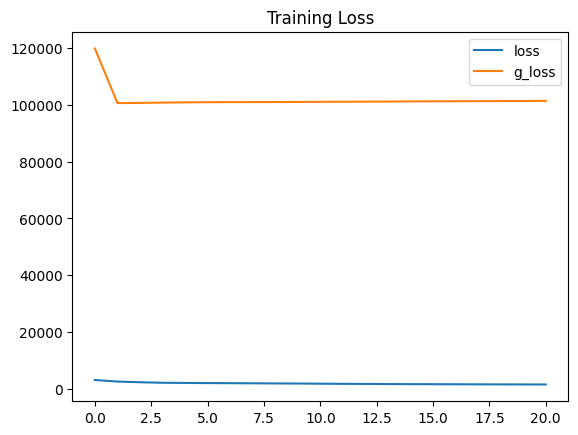

Predicting and Formatting the results.


100%|██████████| 217/217 [00:40<00:00,  5.37it/s]


Evaluating.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 2.3810 2.3191 2.3191
Cyclist AP@0.5: 18.1818 66.7464 66.7464
Car AP@0.7: 21.3957 18.3725 17.8424
==========AOS==========
Pedestrian AOS@0.5: 0.9468 0.7570 0.7570
Cyclist AOS@0.5: 1.2244 6.6032 6.6032
Car AOS@0.7: 20.3045 18.2853 17.6131
==========BBOX_BEV==========
Pedestrian AP@0.5: 13.6364 12.4304 12.4304
Cyclist AP@0.5: 18.1818 11.4833 11.4833
Car AP@0.7: 18.9731 12.3616 11.6811
==========BBOX_3D==========
Pedestrian AP@0.5: 2.1645 2.1336 2.1336
Cyclist AP@0.5: 18.1818 7.1770 7.1770
Car AP@0.7: 2.6870 1.9469 1.8246

==========Overall==========
bbox_2d AP: 13.9862 29.1460 28.9693
AOS AP: 7.4919 8.5485 8.3244
bbox_bev AP: 16.9304 12.0918 11.8649
bbox_3d AP: 7.6778 3.7525 3.7117
==================== 21 ====================


100%|██████████| 1317/1317 [09:11<00:00,  2.39it/s]


==================== 22 ====================


100%|██████████| 1317/1317 [09:10<00:00,  2.39it/s]


==================== 23 ====================


100%|██████████| 1317/1317 [09:11<00:00,  2.39it/s]


==================== 24 ====================


100%|██████████| 1317/1317 [09:08<00:00,  2.40it/s]


==================== 25 ====================


100%|██████████| 1317/1317 [09:10<00:00,  2.39it/s]


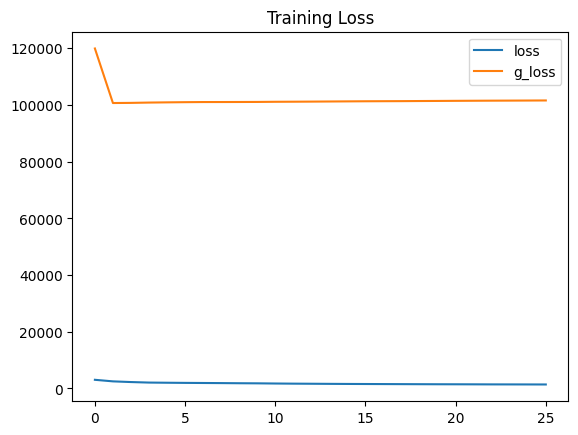

Predicting and Formatting the results.


100%|██████████| 217/217 [00:40<00:00,  5.42it/s]


Evaluating.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 30.8442 28.1076 28.1076
Cyclist AP@0.5: 15.9091 67.8230 67.8230
Car AP@0.7: 81.1007 51.7419 49.4634
==========AOS==========
Pedestrian AOS@0.5: 12.7475 11.7303 11.7303
Cyclist AOS@0.5: 0.7409 7.8696 7.8696
Car AOS@0.7: 80.7645 61.8581 59.1627
==========BBOX_BEV==========
Pedestrian AP@0.5: 65.7468 52.6902 52.6902
Cyclist AP@0.5: 15.9091 20.3349 20.3349
Car AP@0.7: 50.0364 30.3684 29.0909
==========BBOX_3D==========
Pedestrian AP@0.5: 51.9481 41.2338 41.2338
Cyclist AP@0.5: 3.4091 11.4833 11.4833
Car AP@0.7: 19.3578 11.7435 10.8926

==========Overall==========
bbox_2d AP: 42.6180 49.2242 48.4646
AOS AP: 31.4176 27.1527 26.2542
bbox_bev AP: 43.8974 34.4645 34.0387
bbox_3d AP: 24.9050 21.4868 21.2032
==================== 26 ====================


100%|██████████| 1317/1317 [09:07<00:00,  2.41it/s]


==================== 27 ====================


100%|██████████| 1317/1317 [09:10<00:00,  2.39it/s]


==================== 28 ====================


100%|██████████| 1317/1317 [09:10<00:00,  2.39it/s]


==================== 29 ====================


100%|██████████| 1317/1317 [09:06<00:00,  2.41it/s]


==================== 30 ====================


100%|██████████| 1317/1317 [09:07<00:00,  2.41it/s]


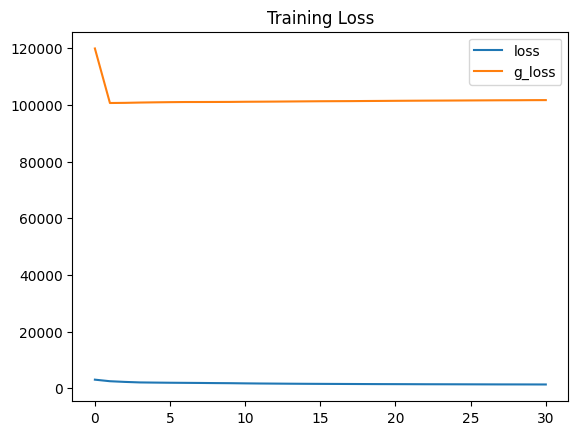

Predicting and Formatting the results.


100%|██████████| 217/217 [00:39<00:00,  5.46it/s]


Evaluating.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 6.6558 6.2616 6.2616
Cyclist AP@0.5: 15.9091 66.7464 66.7464
Car AP@0.7: 56.9770 41.2338 39.0102
==========AOS==========
Pedestrian AOS@0.5: 1.4015 1.4122 1.4122
Cyclist AOS@0.5: 0.4781 17.4956 17.4956
Car AOS@0.7: 59.3704 49.6266 47.6595
==========BBOX_BEV==========
Pedestrian AP@0.5: 31.4935 27.5510 27.5510
Cyclist AP@0.5: 15.9091 38.5167 38.5167
Car AP@0.7: 43.3769 30.8596 29.2817
==========BBOX_3D==========
Pedestrian AP@0.5: 11.9048 10.2041 10.2041
Cyclist AP@0.5: 11.3636 20.3349 20.3349
Car AP@0.7: 13.6814 10.8782 7.4543

==========Overall==========
bbox_2d AP: 26.5140 38.0806 37.3394
AOS AP: 20.4167 22.8448 22.1891
bbox_bev AP: 30.2598 32.3091 31.7832
bbox_3d AP: 12.3166 13.8057 12.6644
==================== 31 ====================


100%|██████████| 1317/1317 [09:08<00:00,  2.40it/s]


==================== 32 ====================


100%|██████████| 1317/1317 [09:08<00:00,  2.40it/s]


==================== 33 ====================


100%|██████████| 1317/1317 [09:08<00:00,  2.40it/s]


==================== 34 ====================


100%|██████████| 1317/1317 [09:08<00:00,  2.40it/s]


==================== 35 ====================


100%|██████████| 1317/1317 [09:10<00:00,  2.39it/s]


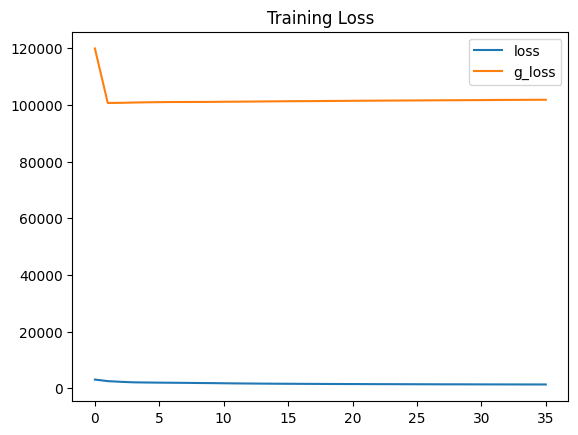

Predicting and Formatting the results.


100%|██████████| 217/217 [00:39<00:00,  5.52it/s]


Evaluating.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 2.8139 2.6902 2.6902
Cyclist AP@0.5: 18.1818 53.5885 53.5885
Car AP@0.7: 84.8789 55.3700 53.7198
==========AOS==========
Pedestrian AOS@0.5: 0.5938 0.6644 0.6644
Cyclist AOS@0.5: 3.8815 10.1633 10.1633
Car AOS@0.7: 84.7130 66.3130 64.7445
==========BBOX_BEV==========
Pedestrian AP@0.5: 20.2922 18.5529 18.5529
Cyclist AP@0.5: 18.1818 21.5311 21.5311
Car AP@0.7: 55.8936 41.0767 39.6402
==========BBOX_3D==========
Pedestrian AP@0.5: 5.6818 5.4267 5.4267
Cyclist AP@0.5: 15.9091 18.5407 18.5407
Car AP@0.7: 29.8805 19.0682 17.9341

==========Overall==========
bbox_2d AP: 35.2915 37.2162 36.6662
AOS AP: 29.7294 25.7136 25.1907
bbox_bev AP: 31.4559 27.0536 26.5747
bbox_3d AP: 17.1571 14.3452 13.9672
==================== 36 ====================


100%|██████████| 1317/1317 [09:08<00:00,  2.40it/s]


==================== 37 ====================


100%|██████████| 1317/1317 [09:08<00:00,  2.40it/s]


==================== 38 ====================


100%|██████████| 1317/1317 [09:09<00:00,  2.40it/s]


==================== 39 ====================


100%|██████████| 1317/1317 [09:08<00:00,  2.40it/s]


==================== 40 ====================


100%|██████████| 1317/1317 [09:09<00:00,  2.40it/s]


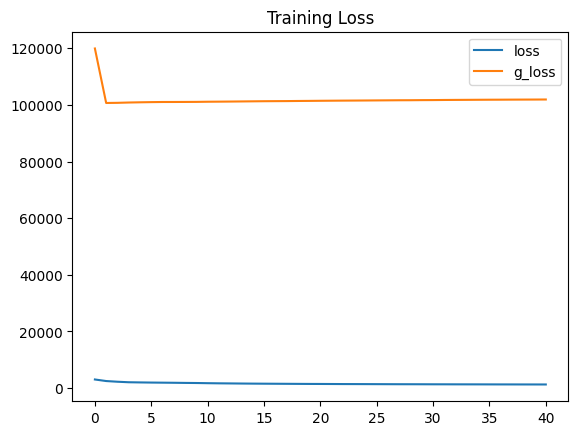

Predicting and Formatting the results.


100%|██████████| 217/217 [00:41<00:00,  5.28it/s]


Evaluating.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 11.2554 10.3896 10.3896
Cyclist AP@0.5: 18.1818 82.5359 82.5359
Car AP@0.7: 65.4545 41.0045 39.2547
==========AOS==========
Pedestrian AOS@0.5: 1.3050 1.2727 1.2727
Cyclist AOS@0.5: 1.0552 4.8186 4.8186
Car AOS@0.7: 66.0070 51.6439 50.1005
==========BBOX_BEV==========
Pedestrian AP@0.5: 30.1948 27.8293 27.8293
Cyclist AP@0.5: 18.1818 49.7608 49.7608
Car AP@0.7: 41.6667 27.9379 26.7083
==========BBOX_3D==========
Pedestrian AP@0.5: 17.5866 12.4304 12.4304
Cyclist AP@0.5: 13.6364 20.9330 20.9330
Car AP@0.7: 18.0382 10.7607 7.4718

==========Overall==========
bbox_2d AP: 31.6306 44.6433 44.0601
AOS AP: 22.7891 19.2451 18.7306
bbox_bev AP: 30.0144 35.1760 34.7661
bbox_3d AP: 16.4204 14.7080 13.6117
==================== 41 ====================


100%|██████████| 1317/1317 [09:09<00:00,  2.40it/s]


==================== 42 ====================


100%|██████████| 1317/1317 [09:09<00:00,  2.40it/s]


==================== 43 ====================


100%|██████████| 1317/1317 [09:08<00:00,  2.40it/s]


==================== 44 ====================


100%|██████████| 1317/1317 [09:09<00:00,  2.40it/s]


==================== 45 ====================


100%|██████████| 1317/1317 [09:06<00:00,  2.41it/s]


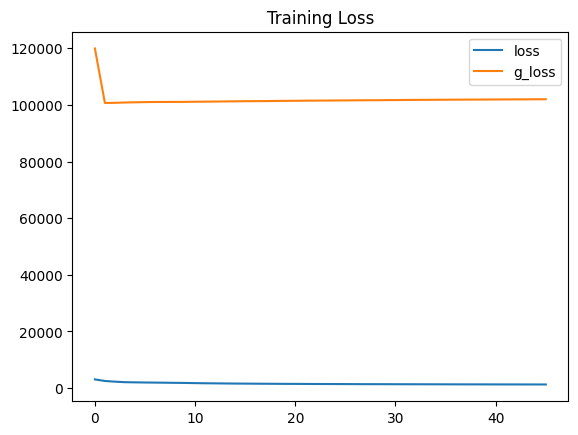

Predicting and Formatting the results.


100%|██████████| 217/217 [00:39<00:00,  5.52it/s]


Evaluating.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 5.1948 5.1484 5.1484
Cyclist AP@0.5: 18.1818 68.8995 68.8995
Car AP@0.7: 70.4568 52.3900 50.1124
==========AOS==========
Pedestrian AOS@0.5: 2.2899 2.0705 2.0705
Cyclist AOS@0.5: 1.5818 13.6661 13.6661
Car AOS@0.7: 71.8899 60.8575 57.5727
==========BBOX_BEV==========
Pedestrian AP@0.5: 12.9870 11.6883 11.6883
Cyclist AP@0.5: 18.1818 37.6794 37.6794
Car AP@0.7: 51.8962 36.9769 30.4376
==========BBOX_3D==========
Pedestrian AP@0.5: 5.6818 4.8701 4.8701
Cyclist AP@0.5: 15.9091 18.5407 18.5407
Car AP@0.7: 18.8459 11.8532 11.1366

==========Overall==========
bbox_2d AP: 31.2778 42.1460 41.3868
AOS AP: 25.2539 25.5314 24.4364
bbox_bev AP: 27.6883 28.7815 26.6018
bbox_3d AP: 13.4789 11.7547 11.5158
==================== 46 ====================


100%|██████████| 1317/1317 [09:09<00:00,  2.40it/s]


==================== 47 ====================


100%|██████████| 1317/1317 [09:11<00:00,  2.39it/s]


==================== 48 ====================


100%|██████████| 1317/1317 [09:04<00:00,  2.42it/s]


==================== 49 ====================


100%|██████████| 1317/1317 [08:58<00:00,  2.44it/s]


==================== 50 ====================


100%|██████████| 1317/1317 [08:58<00:00,  2.45it/s]


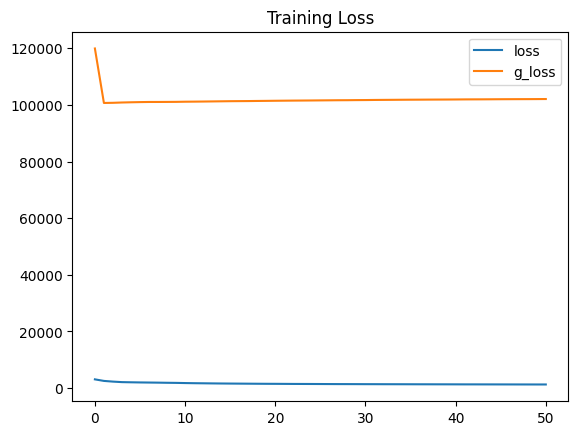

Predicting and Formatting the results.


100%|██████████| 217/217 [00:40<00:00,  5.41it/s]


Evaluating.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 6.3312 6.1224 6.1224
Cyclist AP@0.5: 18.1818 81.3397 81.3397
Car AP@0.7: 85.5239 55.0201 53.1129
==========AOS==========
Pedestrian AOS@0.5: 1.0061 0.9612 0.9612
Cyclist AOS@0.5: 2.6208 8.6338 8.6338
Car AOS@0.7: 85.9428 66.7411 65.4927
==========BBOX_BEV==========
Pedestrian AP@0.5: 39.3939 30.8905 30.8905
Cyclist AP@0.5: 18.1818 39.3541 39.3541
Car AP@0.7: 64.7182 41.7252 39.9255
==========BBOX_3D==========
Pedestrian AP@0.5: 21.1039 19.0167 19.0167
Cyclist AP@0.5: 18.1818 21.5311 21.5311
Car AP@0.7: 30.3030 18.7848 17.5443

==========Overall==========
bbox_2d AP: 36.6790 47.4941 46.8584
AOS AP: 29.8566 25.4454 25.0292
bbox_bev AP: 40.7646 37.3233 36.7234
bbox_3d AP: 23.1962 19.7775 19.3640
==================== 51 ====================


100%|██████████| 1317/1317 [08:58<00:00,  2.44it/s]


==================== 52 ====================


100%|██████████| 1317/1317 [08:59<00:00,  2.44it/s]


==================== 53 ====================


100%|██████████| 1317/1317 [09:01<00:00,  2.43it/s]


==================== 54 ====================


100%|██████████| 1317/1317 [09:02<00:00,  2.43it/s]


==================== 55 ====================


100%|██████████| 1317/1317 [09:00<00:00,  2.43it/s]


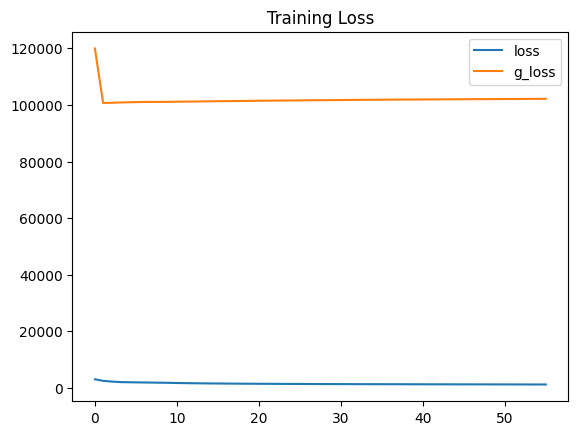

Predicting and Formatting the results.


100%|██████████| 217/217 [00:38<00:00,  5.65it/s]


Evaluating.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 6.0065 5.8442 5.8442
Cyclist AP@0.5: 18.1818 83.7321 83.7321
Car AP@0.7: 82.1348 53.1849 50.7109
==========AOS==========
Pedestrian AOS@0.5: 3.8250 3.5671 3.5671
Cyclist AOS@0.5: 1.4391 7.9691 7.9691
Car AOS@0.7: 82.1338 64.1120 60.4208
==========BBOX_BEV==========
Pedestrian AP@0.5: 28.8961 26.7161 26.7161
Cyclist AP@0.5: 18.1818 49.7608 49.7608
Car AP@0.7: 52.5974 36.7036 29.8171
==========BBOX_3D==========
Pedestrian AP@0.5: 12.1212 11.1317 11.1317
Cyclist AP@0.5: 18.1818 26.5550 26.5550
Car AP@0.7: 21.3771 12.5882 11.6444

==========Overall==========
bbox_2d AP: 35.4410 47.5870 46.7624
AOS AP: 29.1326 25.2161 23.9857
bbox_bev AP: 33.2251 37.7268 35.4313
bbox_3d AP: 17.2267 16.7583 16.4437
==================== 56 ====================


100%|██████████| 1317/1317 [08:59<00:00,  2.44it/s]


==================== 57 ====================


100%|██████████| 1317/1317 [08:59<00:00,  2.44it/s]


==================== 58 ====================


100%|██████████| 1317/1317 [09:02<00:00,  2.43it/s]


==================== 59 ====================


100%|██████████| 1317/1317 [09:00<00:00,  2.44it/s]


==================== 60 ====================


100%|██████████| 1317/1317 [08:59<00:00,  2.44it/s]


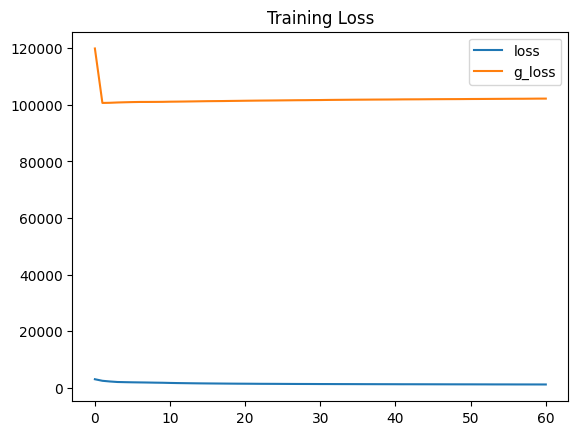

Predicting and Formatting the results.


100%|██████████| 217/217 [00:39<00:00,  5.54it/s]


Evaluating.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 10.8225 7.3748 7.3748
Cyclist AP@0.5: 18.1818 41.0287 41.0287
Car AP@0.7: 2.9707 3.1316 2.8790
==========AOS==========
Pedestrian AOS@0.5: 4.3057 3.6647 3.6647
Cyclist AOS@0.5: 0.6080 6.3837 6.3837
Car AOS@0.7: 3.2107 5.7310 5.7606
==========BBOX_BEV==========
Pedestrian AP@0.5: 37.1212 29.2208 29.2208
Cyclist AP@0.5: 18.1818 27.2727 27.2727
Car AP@0.7: 5.3955 3.1213 2.7965
==========BBOX_3D==========
Pedestrian AP@0.5: 11.2554 7.5139 7.5139
Cyclist AP@0.5: 15.9091 12.9187 12.9187
Car AP@0.7: 0.2416 0.2215 0.1971

==========Overall==========
bbox_2d AP: 10.6583 17.1784 17.0942
AOS AP: 2.7081 5.2598 5.2697
bbox_bev AP: 20.2328 19.8716 19.7633
bbox_3d AP: 9.1354 6.8847 6.8766
==================== 61 ====================


100%|██████████| 1317/1317 [09:00<00:00,  2.44it/s]


==================== 62 ====================


100%|██████████| 1317/1317 [09:02<00:00,  2.43it/s]


==================== 63 ====================


100%|██████████| 1317/1317 [09:01<00:00,  2.43it/s]


==================== 64 ====================


100%|██████████| 1317/1317 [09:02<00:00,  2.43it/s]


==================== 65 ====================


100%|██████████| 1317/1317 [09:02<00:00,  2.43it/s]


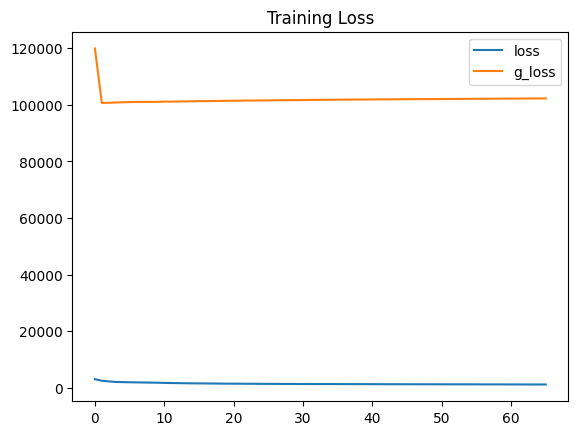

Predicting and Formatting the results.


100%|██████████| 217/217 [00:39<00:00,  5.52it/s]


Evaluating.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 18.1277 13.5436 13.5436
Cyclist AP@0.5: 18.1818 67.8230 67.8230
Car AP@0.7: 70.0260 42.3882 41.1293
==========AOS==========
Pedestrian AOS@0.5: 18.1464 17.3981 17.3981
Cyclist AOS@0.5: 5.9911 16.3412 16.3412
Car AOS@0.7: 73.2825 55.7806 54.6109
==========BBOX_BEV==========
Pedestrian AP@0.5: 39.3939 30.8905 30.8905
Cyclist AP@0.5: 18.1818 40.1914 40.1914
Car AP@0.7: 67.5081 42.0036 40.0174
==========BBOX_3D==========
Pedestrian AP@0.5: 13.2035 12.6160 12.6160
Cyclist AP@0.5: 13.6364 19.1388 19.1388
Car AP@0.7: 12.8152 7.2006 6.8904

==========Overall==========
bbox_2d AP: 35.4452 41.2516 40.8319
AOS AP: 32.4733 29.8400 29.4501
bbox_bev AP: 41.6946 37.6952 37.0331
bbox_3d AP: 13.2183 12.9851 12.8817
==================== 66 ====================


100%|██████████| 1317/1317 [09:00<00:00,  2.44it/s]


==================== 67 ====================


100%|██████████| 1317/1317 [09:00<00:00,  2.44it/s]


==================== 68 ====================


100%|██████████| 1317/1317 [09:03<00:00,  2.42it/s]


==================== 69 ====================


100%|██████████| 1317/1317 [09:01<00:00,  2.43it/s]


==================== 70 ====================


100%|██████████| 1317/1317 [09:01<00:00,  2.43it/s]


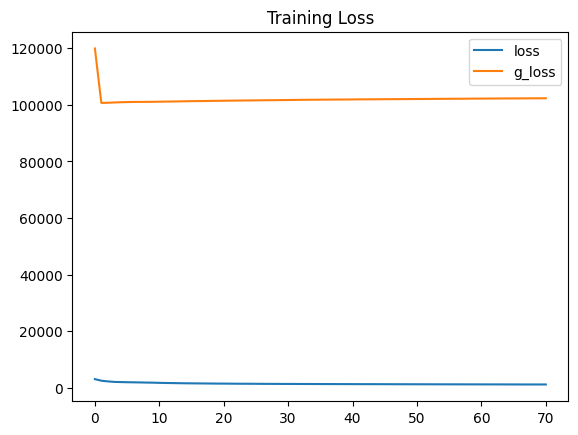

Predicting and Formatting the results.


100%|██████████| 217/217 [00:39<00:00,  5.53it/s]


Evaluating.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 2.8139 2.6902 2.6902
Cyclist AP@0.5: 18.1818 54.5455 54.5455
Car AP@0.7: 82.4566 52.7726 51.7751
==========AOS==========
Pedestrian AOS@0.5: 3.4986 2.3963 2.3963
Cyclist AOS@0.5: 2.9831 9.9155 9.9155
Car AOS@0.7: 83.7590 64.8906 62.8781
==========BBOX_BEV==========
Pedestrian AP@0.5: 29.2208 26.9944 26.9944
Cyclist AP@0.5: 18.1818 41.8660 41.8660
Car AP@0.7: 65.2925 42.8689 41.4294
==========BBOX_3D==========
Pedestrian AP@0.5: 0.7035 1.4842 1.4842
Cyclist AP@0.5: 18.1818 27.9904 27.9904
Car AP@0.7: 21.4459 13.3711 12.7630

==========Overall==========
bbox_2d AP: 34.4841 36.6694 36.3369
AOS AP: 30.0803 25.7341 25.0633
bbox_bev AP: 37.5650 37.2431 36.7633
bbox_3d AP: 13.4437 14.2819 14.0792
==================== 71 ====================


100%|██████████| 1317/1317 [09:00<00:00,  2.44it/s]


==================== 72 ====================


100%|██████████| 1317/1317 [09:01<00:00,  2.43it/s]


==================== 73 ====================


100%|██████████| 1317/1317 [09:00<00:00,  2.44it/s]


==================== 74 ====================


100%|██████████| 1317/1317 [08:58<00:00,  2.45it/s]


==================== 75 ====================


100%|██████████| 1317/1317 [08:59<00:00,  2.44it/s]


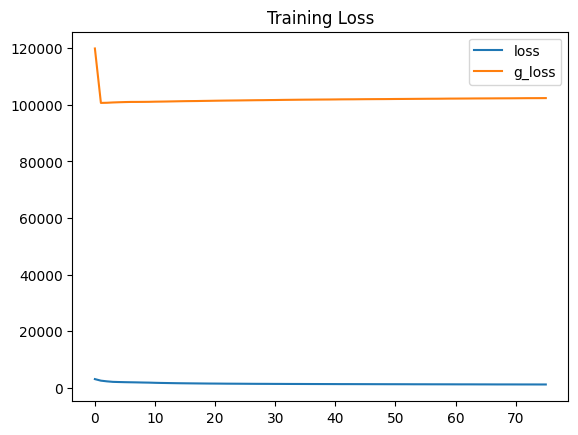

Predicting and Formatting the results.


100%|██████████| 217/217 [00:38<00:00,  5.65it/s]


Evaluating.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 7.1429 6.6790 6.6790
Cyclist AP@0.5: 18.1818 56.4593 56.4593
Car AP@0.7: 82.9961 64.0336 54.6924
==========AOS==========
Pedestrian AOS@0.5: 7.7946 7.4820 7.4820
Cyclist AOS@0.5: 10.7152 21.2421 21.2421
Car AOS@0.7: 83.7363 68.9469 65.3700
==========BBOX_BEV==========
Pedestrian AP@0.5: 21.1039 19.4805 19.4805
Cyclist AP@0.5: 18.1818 41.0287 41.0287
Car AP@0.7: 69.4362 51.8538 49.7086
==========BBOX_3D==========
Pedestrian AP@0.5: 4.8701 3.0612 3.0612
Cyclist AP@0.5: 18.1818 20.3349 20.3349
Car AP@0.7: 21.4696 17.4548 12.9595

==========Overall==========
bbox_2d AP: 36.1069 42.3907 39.2769
AOS AP: 34.0820 32.5570 31.3647
bbox_bev AP: 36.2406 37.4543 36.7393
bbox_3d AP: 14.8405 13.6170 12.1185
==================== 76 ====================


100%|██████████| 1317/1317 [08:59<00:00,  2.44it/s]


==================== 77 ====================


100%|██████████| 1317/1317 [09:02<00:00,  2.43it/s]


==================== 78 ====================


100%|██████████| 1317/1317 [09:00<00:00,  2.44it/s]


==================== 79 ====================


100%|██████████| 1317/1317 [09:00<00:00,  2.44it/s]


==================== 80 ====================


100%|██████████| 1317/1317 [09:01<00:00,  2.43it/s]


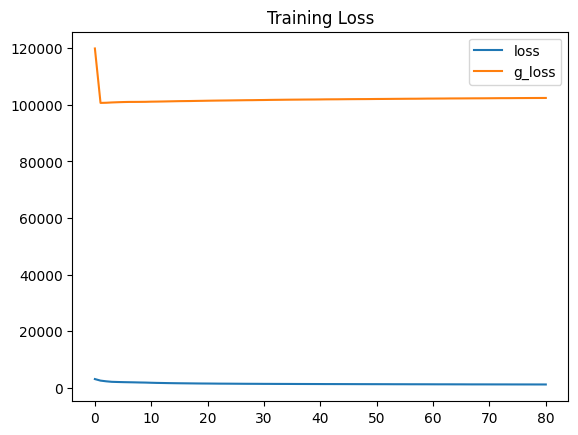

Predicting and Formatting the results.


100%|██████████| 217/217 [00:38<00:00,  5.59it/s]


Evaluating.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 2.3810 2.6902 2.6902
Cyclist AP@0.5: 18.1818 26.5550 26.5550
Car AP@0.7: 53.3286 31.2130 30.1197
==========AOS==========
Pedestrian AOS@0.5: 4.2274 4.2609 4.2609
Cyclist AOS@0.5: 13.5269 10.9315 10.9315
Car AOS@0.7: 56.9062 43.0385 41.8513
==========BBOX_BEV==========
Pedestrian AP@0.5: 65.2597 51.9481 51.9481
Cyclist AP@0.5: 18.1818 20.3349 20.3349
Car AP@0.7: 29.8791 21.0662 20.3778
==========BBOX_3D==========
Pedestrian AP@0.5: 2.3810 2.4119 2.4119
Cyclist AP@0.5: 4.5455 3.1100 3.1100
Car AP@0.7: 5.1807 2.5032 2.3381

==========Overall==========
bbox_2d AP: 24.6304 20.1527 19.7883
AOS AP: 24.8868 19.4103 19.0146
bbox_bev AP: 37.7735 31.1164 30.8869
bbox_3d AP: 4.0357 2.6750 2.6200
==================== 81 ====================


100%|██████████| 1317/1317 [09:00<00:00,  2.44it/s]


==================== 82 ====================


100%|██████████| 1317/1317 [09:02<00:00,  2.43it/s]


==================== 83 ====================


100%|██████████| 1317/1317 [08:59<00:00,  2.44it/s]


==================== 84 ====================


100%|██████████| 1317/1317 [09:01<00:00,  2.43it/s]


==================== 85 ====================


100%|██████████| 1317/1317 [08:59<00:00,  2.44it/s]


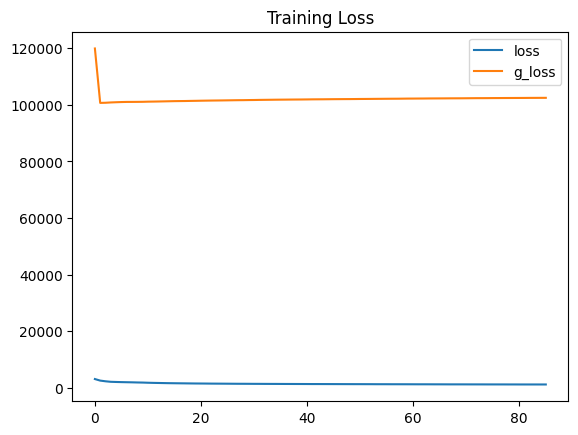

Predicting and Formatting the results.


100%|██████████| 217/217 [00:37<00:00,  5.72it/s]


Evaluating.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 21.3745 20.1763 20.1763
Cyclist AP@0.5: 18.1818 53.5885 53.5885
Car AP@0.7: 83.5989 54.0899 51.9375
==========AOS==========
Pedestrian AOS@0.5: 15.4967 15.1514 15.1514
Cyclist AOS@0.5: 13.5917 19.9356 19.9356
Car AOS@0.7: 84.8342 66.9901 64.3041
==========BBOX_BEV==========
Pedestrian AP@0.5: 53.6797 42.5325 42.5325
Cyclist AP@0.5: 15.9091 31.5789 31.5789
Car AP@0.7: 56.7881 41.3510 39.5595
==========BBOX_3D==========
Pedestrian AP@0.5: 18.9394 17.8571 17.8571
Cyclist AP@0.5: 13.6364 13.3971 13.3971
Car AP@0.7: 27.6305 18.6454 17.3979

==========Overall==========
bbox_2d AP: 41.0517 42.6182 41.9008
AOS AP: 37.9742 34.0257 33.1304
bbox_bev AP: 42.1256 38.4875 37.8903
bbox_3d AP: 20.0688 16.6332 16.2174
==================== 86 ====================


100%|██████████| 1317/1317 [08:59<00:00,  2.44it/s]


==================== 87 ====================


100%|██████████| 1317/1317 [08:56<00:00,  2.46it/s]


==================== 88 ====================


100%|██████████| 1317/1317 [08:52<00:00,  2.47it/s]


==================== 89 ====================


100%|██████████| 1317/1317 [08:59<00:00,  2.44it/s]


==================== 90 ====================


100%|██████████| 1317/1317 [08:58<00:00,  2.45it/s]


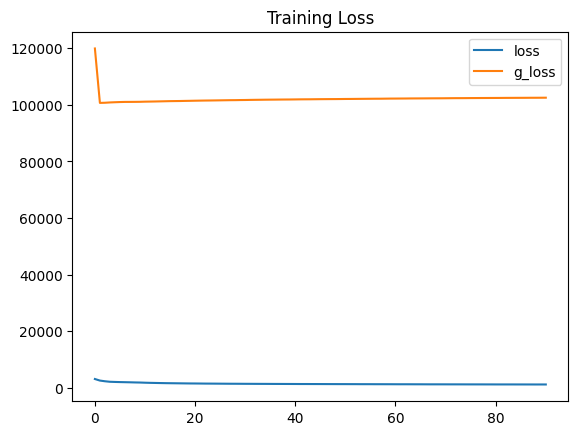

Predicting and Formatting the results.


100%|██████████| 217/217 [00:39<00:00,  5.51it/s]


Evaluating.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 17.5866 13.1725 13.1725
Cyclist AP@0.5: 18.1818 64.5933 64.5933
Car AP@0.7: 56.0711 39.2496 37.5975
==========AOS==========
Pedestrian AOS@0.5: 5.1358 4.8084 4.8084
Cyclist AOS@0.5: 3.9777 15.5038 15.5038
Car AOS@0.7: 61.1871 49.9234 48.1895
==========BBOX_BEV==========
Pedestrian AP@0.5: 38.6364 30.3340 30.3340
Cyclist AP@0.5: 18.1818 41.0287 41.0287
Car AP@0.7: 29.9328 19.4695 18.5669
==========BBOX_3D==========
Pedestrian AP@0.5: 10.6061 10.2041 10.2041
Cyclist AP@0.5: 18.1818 30.1435 30.1435
Car AP@0.7: 6.1263 4.8210 3.0349

==========Overall==========
bbox_2d AP: 30.6132 39.0052 38.4544
AOS AP: 23.4335 23.4119 22.8339
bbox_bev AP: 28.9170 30.2774 29.9765
bbox_3d AP: 11.6381 15.0562 14.4608
==================== 91 ====================


100%|██████████| 1317/1317 [08:54<00:00,  2.46it/s]


==================== 92 ====================


100%|██████████| 1317/1317 [08:53<00:00,  2.47it/s]


==================== 93 ====================


100%|██████████| 1317/1317 [08:56<00:00,  2.46it/s]


==================== 94 ====================


100%|██████████| 1317/1317 [08:56<00:00,  2.45it/s]


==================== 95 ====================


100%|██████████| 1317/1317 [08:54<00:00,  2.46it/s]


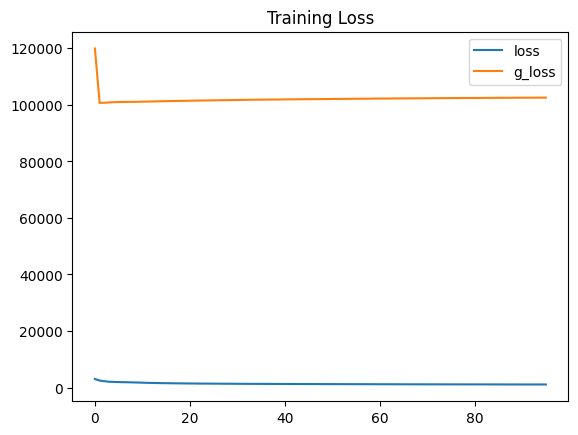

Predicting and Formatting the results.


100%|██████████| 217/217 [00:38<00:00,  5.66it/s]


Evaluating.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 18.9394 17.6252 17.6252
Cyclist AP@0.5: 18.1818 83.7321 83.7321
Car AP@0.7: 68.3299 51.4000 43.0132
==========AOS==========
Pedestrian AOS@0.5: 8.4301 8.0330 8.0330
Cyclist AOS@0.5: 10.1789 43.3201 43.3201
Car AOS@0.7: 73.2210 60.1851 55.3267
==========BBOX_BEV==========
Pedestrian AP@0.5: 29.8701 26.9944 26.9944
Cyclist AP@0.5: 18.1818 54.5455 54.5455
Car AP@0.7: 42.5286 30.1622 28.8819
==========BBOX_3D==========
Pedestrian AP@0.5: 10.6061 7.0965 7.0965
Cyclist AP@0.5: 18.1818 27.9904 27.9904
Car AP@0.7: 11.5247 6.3662 5.9414

==========Overall==========
bbox_2d AP: 35.1504 50.9191 48.1235
AOS AP: 30.6100 37.1794 35.5600
bbox_bev AP: 30.1935 37.2340 36.8072
bbox_3d AP: 13.4375 13.8177 13.6761
==================== 96 ====================


100%|██████████| 1317/1317 [08:56<00:00,  2.45it/s]


==================== 97 ====================


100%|██████████| 1317/1317 [08:54<00:00,  2.46it/s]


==================== 98 ====================


100%|██████████| 1317/1317 [08:56<00:00,  2.46it/s]


==================== 99 ====================


100%|██████████| 1317/1317 [08:55<00:00,  2.46it/s]


==================== 100 ====================


100%|██████████| 1317/1317 [08:56<00:00,  2.46it/s]


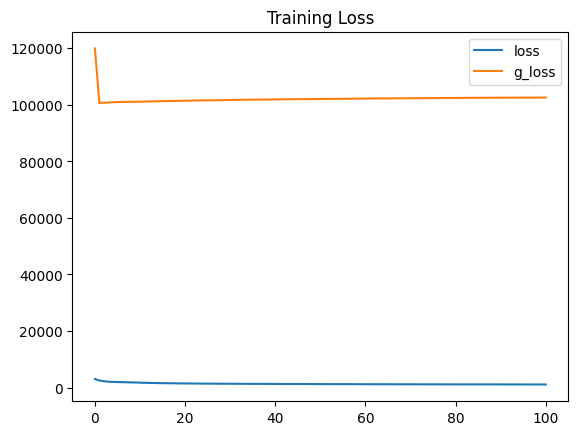

Predicting and Formatting the results.


100%|██████████| 217/217 [00:38<00:00,  5.64it/s]


Evaluating.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 2.2727 2.3191 2.3191
Cyclist AP@0.5: 18.1818 71.0526 71.0526
Car AP@0.7: 50.0134 31.2925 29.6395
==========AOS==========
Pedestrian AOS@0.5: 0.5241 0.6798 0.6798
Cyclist AOS@0.5: 12.8683 55.3605 55.3605
Car AOS@0.7: 46.9064 37.3984 36.8286
==========BBOX_BEV==========
Pedestrian AP@0.5: 18.6688 17.3933 17.3933
Cyclist AP@0.5: 18.1818 55.5024 55.5024
Car AP@0.7: 20.6001 19.3517 18.9661
==========BBOX_3D==========
Pedestrian AP@0.5: 1.5152 1.4842 1.4842
Cyclist AP@0.5: 18.1818 30.1435 30.1435
Car AP@0.7: 5.2127 2.8345 2.5869

==========Overall==========
bbox_2d AP: 23.4893 34.8881 34.3371
AOS AP: 20.0996 31.1462 30.9563
bbox_bev AP: 19.1502 30.7491 30.6206
bbox_3d AP: 8.3032 11.4874 11.4049
==================== 101 ====================


100%|██████████| 1317/1317 [08:55<00:00,  2.46it/s]


==================== 102 ====================


100%|██████████| 1317/1317 [08:56<00:00,  2.45it/s]


==================== 103 ====================


100%|██████████| 1317/1317 [08:53<00:00,  2.47it/s]


==================== 104 ====================


100%|██████████| 1317/1317 [08:54<00:00,  2.47it/s]


==================== 105 ====================


100%|██████████| 1317/1317 [08:54<00:00,  2.47it/s]


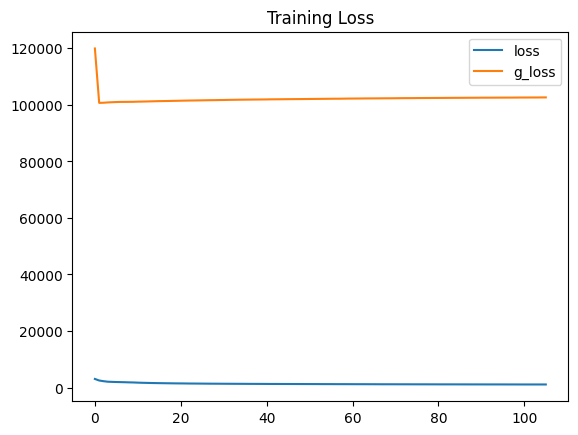

Predicting and Formatting the results.


100%|██████████| 217/217 [00:38<00:00,  5.71it/s]


Evaluating.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 6.3312 6.1224 6.1224
Cyclist AP@0.5: 18.1818 82.5359 82.5359
Car AP@0.7: 30.5240 19.0317 17.4666
==========AOS==========
Pedestrian AOS@0.5: 3.9485 3.6968 3.6968
Cyclist AOS@0.5: 10.1301 13.0527 13.0527
Car AOS@0.7: 28.6017 17.0296 16.1168
==========BBOX_BEV==========
Pedestrian AP@0.5: 13.2035 12.4304 12.4304
Cyclist AP@0.5: 18.1818 50.7177 50.7177
Car AP@0.7: 26.9234 18.4909 13.5516
==========BBOX_3D==========
Pedestrian AP@0.5: 5.0325 5.0093 5.0093
Cyclist AP@0.5: 18.1818 18.5407 18.5407
Car AP@0.7: 5.6908 2.7401 2.4481

==========Overall==========
bbox_2d AP: 18.3456 35.8967 35.3750
AOS AP: 14.2267 11.2597 10.9554
bbox_bev AP: 19.4362 27.2130 25.5666
bbox_3d AP: 9.6350 8.7634 8.6660
==================== 106 ====================


100%|██████████| 1317/1317 [08:56<00:00,  2.46it/s]


==================== 107 ====================


100%|██████████| 1317/1317 [08:51<00:00,  2.48it/s]


==================== 108 ====================


100%|██████████| 1317/1317 [08:51<00:00,  2.48it/s]


==================== 109 ====================


100%|██████████| 1317/1317 [08:53<00:00,  2.47it/s]


==================== 110 ====================


100%|██████████| 1317/1317 [08:54<00:00,  2.46it/s]


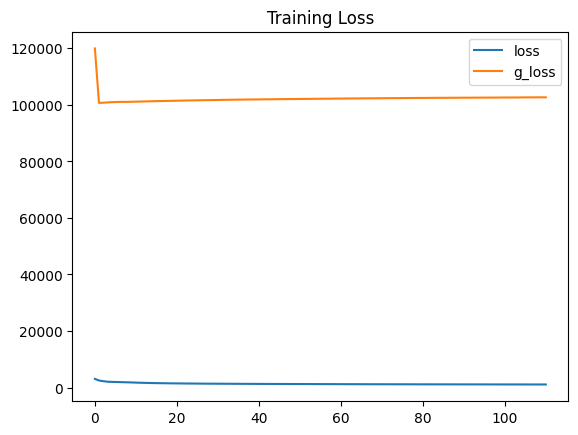

Predicting and Formatting the results.


100%|██████████| 217/217 [00:38<00:00,  5.59it/s]


Evaluating.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 6.0065 5.5659 5.5659
Cyclist AP@0.5: 18.1818 20.3349 20.3349
Car AP@0.7: 17.4928 10.5279 7.2755
==========AOS==========
Pedestrian AOS@0.5: 1.9823 1.8448 1.8448
Cyclist AOS@0.5: 5.1863 12.6340 12.6340
Car AOS@0.7: 12.5864 7.5413 6.7093
==========BBOX_BEV==========
Pedestrian AP@0.5: 4.8701 3.0612 3.0612
Cyclist AP@0.5: 18.1818 19.1388 19.1388
Car AP@0.7: 6.8182 5.2691 4.8136
==========BBOX_3D==========
Pedestrian AP@0.5: 0.1623 0.2783 0.2783
Cyclist AP@0.5: 15.9091 11.4833 11.4833
Car AP@0.7: 0.4116 0.2575 0.2292

==========Overall==========
bbox_2d AP: 13.8937 12.1429 11.0588
AOS AP: 6.5850 7.3401 7.0627
bbox_bev AP: 9.9567 9.1564 9.0045
bbox_3d AP: 5.4943 4.0064 3.9969
==================== 111 ====================


100%|██████████| 1317/1317 [08:54<00:00,  2.46it/s]


==================== 112 ====================


100%|██████████| 1317/1317 [08:54<00:00,  2.47it/s]


==================== 113 ====================


100%|██████████| 1317/1317 [08:52<00:00,  2.47it/s]


==================== 114 ====================


100%|██████████| 1317/1317 [08:55<00:00,  2.46it/s]


==================== 115 ====================


100%|██████████| 1317/1317 [08:55<00:00,  2.46it/s]


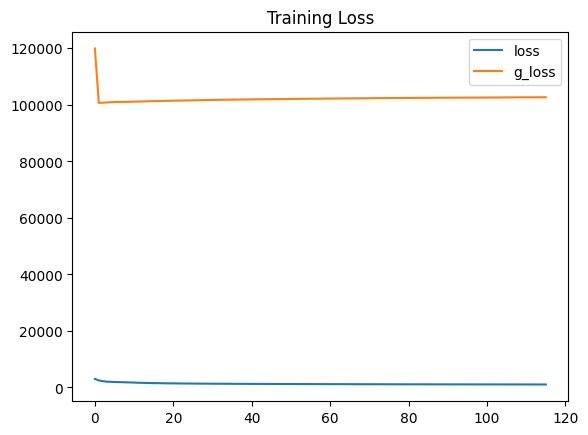

Predicting and Formatting the results.


100%|██████████| 217/217 [00:37<00:00,  5.74it/s]


Evaluating.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 30.5195 28.3859 28.3859
Cyclist AP@0.5: 18.1818 52.6316 52.6316
Car AP@0.7: 40.4617 26.7937 26.3513
==========AOS==========
Pedestrian AOS@0.5: 4.2501 4.0134 4.0134
Cyclist AOS@0.5: 2.6407 17.2724 17.2724
Car AOS@0.7: 41.2357 32.4609 32.6032
==========BBOX_BEV==========
Pedestrian AP@0.5: 42.8030 38.9610 38.9610
Cyclist AP@0.5: 18.1818 50.7177 50.7177
Car AP@0.7: 17.6444 13.0003 12.8547
==========BBOX_3D==========
Pedestrian AP@0.5: 17.8571 13.1725 13.1725
Cyclist AP@0.5: 18.1818 27.2727 27.2727
Car AP@0.7: 2.6306 1.7924 1.6687

==========Overall==========
bbox_2d AP: 29.7210 35.9371 35.7896
AOS AP: 16.0421 17.9155 17.9630
bbox_bev AP: 26.2098 34.2263 34.1778
bbox_3d AP: 12.8899 14.0792 14.0380
==================== 116 ====================


100%|██████████| 1317/1317 [08:52<00:00,  2.47it/s]


==================== 117 ====================


100%|██████████| 1317/1317 [08:52<00:00,  2.47it/s]


==================== 118 ====================


100%|██████████| 1317/1317 [08:55<00:00,  2.46it/s]


==================== 119 ====================


100%|██████████| 1317/1317 [08:52<00:00,  2.47it/s]


==================== 120 ====================


100%|██████████| 1317/1317 [08:53<00:00,  2.47it/s]


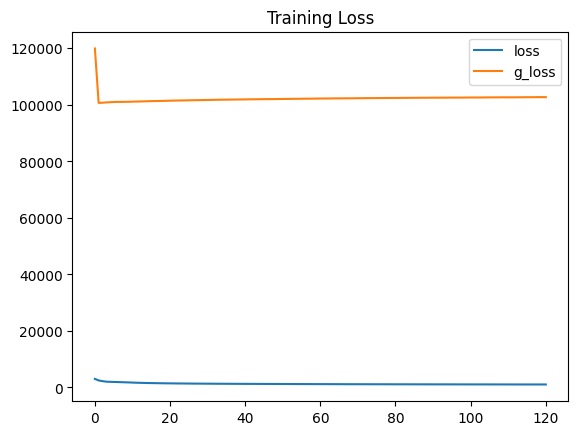

Predicting and Formatting the results.


100%|██████████| 217/217 [00:38<00:00,  5.60it/s]


Evaluating.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 0.3788 0.3711 0.3711
Cyclist AP@0.5: 15.9091 71.0526 71.0526
Car AP@0.7: 28.4585 19.7270 18.6586
==========AOS==========
Pedestrian AOS@0.5: 0.0322 0.0322 0.0322
Cyclist AOS@0.5: 2.4441 35.0569 35.0569
Car AOS@0.7: 35.6258 29.5915 28.1493
==========BBOX_BEV==========
Pedestrian AP@0.5: 2.0563 2.1336 2.1336
Cyclist AP@0.5: 15.9091 50.7177 50.7177
Car AP@0.7: 19.8640 18.8879 18.5304
==========BBOX_3D==========
Pedestrian AP@0.5: 0.0541 0.0464 0.0464
Cyclist AP@0.5: 4.5455 21.5311 21.5311
Car AP@0.7: 2.5054 1.8130 1.6412

==========Overall==========
bbox_2d AP: 14.9155 30.3836 30.0274
AOS AP: 12.7007 21.5602 21.0795
bbox_bev AP: 12.6098 23.9130 23.7939
bbox_3d AP: 2.3683 7.7968 7.7396
==================== 121 ====================


100%|██████████| 1317/1317 [08:55<00:00,  2.46it/s]


==================== 122 ====================


100%|██████████| 1317/1317 [08:54<00:00,  2.47it/s]


==================== 123 ====================


100%|██████████| 1317/1317 [08:53<00:00,  2.47it/s]


==================== 124 ====================


100%|██████████| 1317/1317 [08:54<00:00,  2.46it/s]


==================== 125 ====================


100%|██████████| 1317/1317 [08:53<00:00,  2.47it/s]


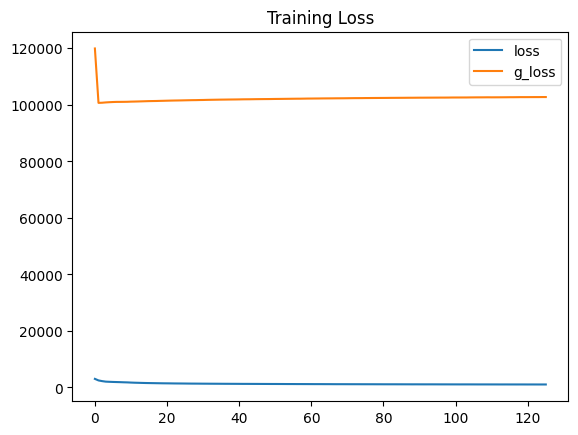

Predicting and Formatting the results.


100%|██████████| 217/217 [00:38<00:00,  5.62it/s]


Evaluating.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 29.5455 26.4378 26.4378
Cyclist AP@0.5: 18.1818 80.1435 80.1435
Car AP@0.7: 66.1561 51.9835 49.6001
==========AOS==========
Pedestrian AOS@0.5: 3.4073 3.2523 3.2523
Cyclist AOS@0.5: 14.5363 28.6566 28.6566
Car AOS@0.7: 66.8344 55.8210 52.8367
==========BBOX_BEV==========
Pedestrian AP@0.5: 31.4935 27.8293 27.8293
Cyclist AP@0.5: 18.1818 64.5933 64.5933
Car AP@0.7: 67.0239 49.7107 41.8559
==========BBOX_3D==========
Pedestrian AP@0.5: 27.5974 20.1763 20.1763
Cyclist AP@0.5: 18.1818 26.5550 26.5550
Car AP@0.7: 6.2045 5.9867 5.5619

==========Overall==========
bbox_2d AP: 37.9611 52.8550 52.0605
AOS AP: 28.2593 29.2433 28.2485
bbox_bev AP: 38.8997 47.3778 44.7595
bbox_3d AP: 17.3279 17.5727 17.4311
==================== 126 ====================


100%|██████████| 1317/1317 [08:53<00:00,  2.47it/s]


==================== 127 ====================


100%|██████████| 1317/1317 [08:53<00:00,  2.47it/s]


==================== 128 ====================


100%|██████████| 1317/1317 [08:54<00:00,  2.46it/s]


==================== 129 ====================


100%|██████████| 1317/1317 [08:52<00:00,  2.47it/s]


==================== 130 ====================


100%|██████████| 1317/1317 [08:53<00:00,  2.47it/s]


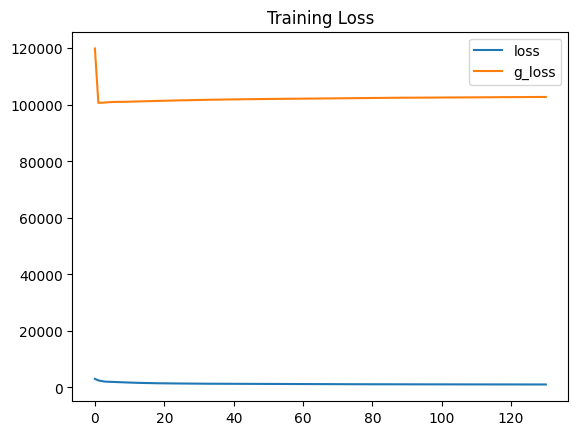

Predicting and Formatting the results.


100%|██████████| 217/217 [00:38<00:00,  5.57it/s]


Evaluating.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 2.0563 2.1336 2.1336
Cyclist AP@0.5: 18.1818 84.9282 84.9282
Car AP@0.7: 55.2985 38.4342 30.4497
==========AOS==========
Pedestrian AOS@0.5: 0.3454 0.3514 0.3514
Cyclist AOS@0.5: 9.3996 33.7802 33.7802
Car AOS@0.7: 58.2942 47.0187 42.9578
==========BBOX_BEV==========
Pedestrian AP@0.5: 2.9221 2.9685 2.9685
Cyclist AP@0.5: 18.1818 53.5885 53.5885
Car AP@0.7: 43.1166 30.3168 28.4693
==========BBOX_3D==========
Pedestrian AP@0.5: 0.2165 0.3711 0.3711
Cyclist AP@0.5: 18.1818 31.5789 31.5789
Car AP@0.7: 11.8343 6.6907 6.0789

==========Overall==========
bbox_2d AP: 25.1789 41.8320 39.1705
AOS AP: 22.6797 27.0501 25.6965
bbox_bev AP: 21.4068 28.9579 28.3421
bbox_3d AP: 10.0775 12.8802 12.6763
==================== 131 ====================


100%|██████████| 1317/1317 [08:54<00:00,  2.46it/s]


==================== 132 ====================


100%|██████████| 1317/1317 [08:51<00:00,  2.48it/s]


==================== 133 ====================


100%|██████████| 1317/1317 [08:51<00:00,  2.48it/s]


==================== 134 ====================


100%|██████████| 1317/1317 [08:52<00:00,  2.48it/s]


==================== 135 ====================


100%|██████████| 1317/1317 [08:53<00:00,  2.47it/s]


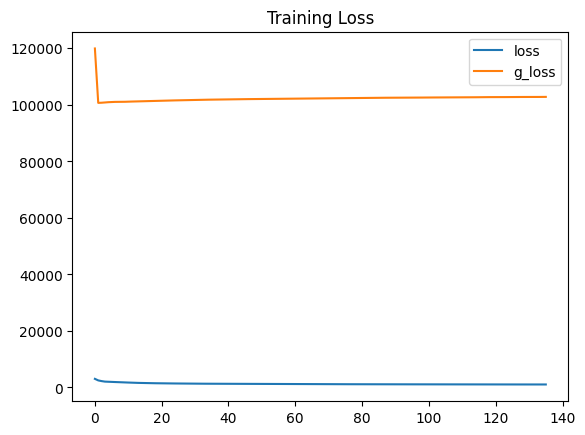

Predicting and Formatting the results.


100%|██████████| 217/217 [00:37<00:00,  5.72it/s]


Evaluating.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 18.9394 18.3210 18.3210
Cyclist AP@0.5: 18.1818 71.0526 71.0526
Car AP@0.7: 51.6614 36.6730 29.2965
==========AOS==========
Pedestrian AOS@0.5: 1.6660 1.6898 1.6898
Cyclist AOS@0.5: 1.0297 35.2961 35.2961
Car AOS@0.7: 53.0466 42.7981 39.9496
==========BBOX_BEV==========
Pedestrian AP@0.5: 52.3810 41.5584 41.5584
Cyclist AP@0.5: 18.1818 50.7177 50.7177
Car AP@0.7: 39.4596 28.2313 26.4746
==========BBOX_3D==========
Pedestrian AP@0.5: 26.2987 20.4082 20.4082
Cyclist AP@0.5: 18.1818 21.5311 21.5311
Car AP@0.7: 5.5029 2.9153 2.6590

==========Overall==========
bbox_2d AP: 29.5942 42.0155 39.5567
AOS AP: 18.5808 26.5947 25.6452
bbox_bev AP: 36.6741 40.1691 39.5836
bbox_3d AP: 16.6611 14.9515 14.8661
==================== 136 ====================


100%|██████████| 1317/1317 [08:52<00:00,  2.47it/s]


==================== 137 ====================


100%|██████████| 1317/1317 [08:52<00:00,  2.47it/s]


==================== 138 ====================


100%|██████████| 1317/1317 [08:54<00:00,  2.47it/s]


==================== 139 ====================


100%|██████████| 1317/1317 [08:52<00:00,  2.47it/s]


==================== 140 ====================


100%|██████████| 1317/1317 [08:52<00:00,  2.47it/s]


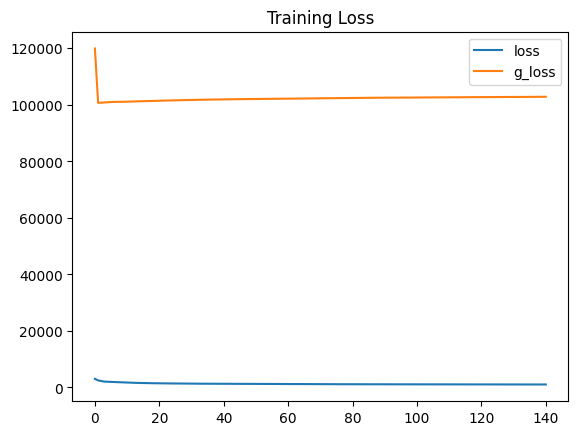

Predicting and Formatting the results.


100%|██████████| 217/217 [00:38<00:00,  5.66it/s]


Evaluating.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 0.2706 0.3247 0.3247
Cyclist AP@0.5: 15.9091 65.6699 65.6699
Car AP@0.7: 70.7051 55.4525 53.0960
==========AOS==========
Pedestrian AOS@0.5: 0.0119 0.0247 0.0247
Cyclist AOS@0.5: 0.7697 11.5141 11.5141
Car AOS@0.7: 73.6945 63.2046 61.4223
==========BBOX_BEV==========
Pedestrian AP@0.5: 0.5411 0.6030 0.6030
Cyclist AP@0.5: 15.9091 53.5885 53.5885
Car AP@0.7: 37.8311 29.9011 29.5844
==========BBOX_3D==========
Pedestrian AP@0.5: 0.1082 0.1855 0.1855
Cyclist AP@0.5: 11.3636 27.2727 27.2727
Car AP@0.7: 6.3350 5.6432 5.4766

==========Overall==========
bbox_2d AP: 28.9616 40.4823 39.6969
AOS AP: 24.8254 24.9145 24.3204
bbox_bev AP: 18.0938 28.0308 27.9253
bbox_3d AP: 5.9356 11.0338 10.9783
==================== 141 ====================


100%|██████████| 1317/1317 [08:54<00:00,  2.46it/s]


==================== 142 ====================


100%|██████████| 1317/1317 [08:53<00:00,  2.47it/s]


==================== 143 ====================


100%|██████████| 1317/1317 [08:54<00:00,  2.46it/s]


==================== 144 ====================


100%|██████████| 1317/1317 [08:55<00:00,  2.46it/s]


==================== 145 ====================


100%|██████████| 1317/1317 [08:50<00:00,  2.48it/s]


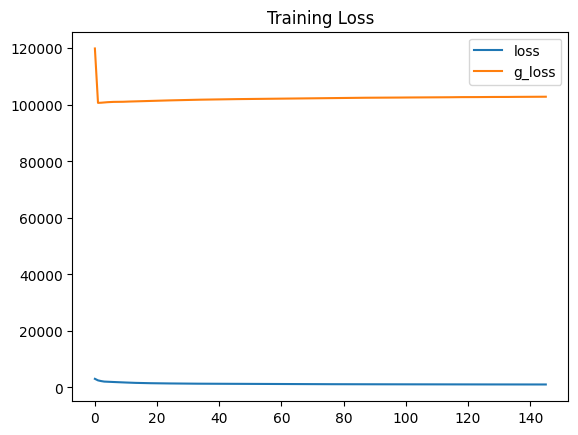

Predicting and Formatting the results.


100%|██████████| 217/217 [00:38<00:00,  5.65it/s]


Evaluating.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 3.0303 3.0612 3.0612
Cyclist AP@0.5: 18.1818 87.3206 87.3206
Car AP@0.7: 85.4456 67.0603 64.7607
==========AOS==========
Pedestrian AOS@0.5: 4.7841 4.6837 4.6837
Cyclist AOS@0.5: 7.3190 35.8422 35.8422
Car AOS@0.7: 85.4859 71.8392 67.8462
==========BBOX_BEV==========
Pedestrian AP@0.5: 17.5866 13.3581 13.3581
Cyclist AP@0.5: 18.1818 67.8230 67.8230
Car AP@0.7: 67.8728 51.9893 50.0138
==========BBOX_3D==========
Pedestrian AP@0.5: 3.0303 3.1540 3.1540
Cyclist AP@0.5: 15.9091 49.7608 49.7608
Car AP@0.7: 20.6001 13.0827 12.4146

==========Overall==========
bbox_2d AP: 35.5526 52.4807 51.7142
AOS AP: 32.5297 37.4550 36.1240
bbox_bev AP: 34.5471 44.3901 43.7316
bbox_3d AP: 13.1798 21.9991 21.7765
==================== 146 ====================


100%|██████████| 1317/1317 [08:52<00:00,  2.47it/s]


==================== 147 ====================


100%|██████████| 1317/1317 [08:50<00:00,  2.48it/s]


==================== 148 ====================


100%|██████████| 1317/1317 [08:55<00:00,  2.46it/s]


==================== 149 ====================


100%|██████████| 1317/1317 [08:54<00:00,  2.47it/s]


==================== 150 ====================


100%|██████████| 1317/1317 [08:55<00:00,  2.46it/s]


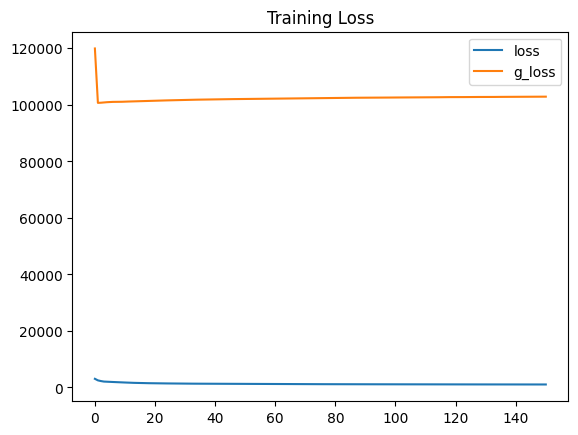

Predicting and Formatting the results.


100%|██████████| 217/217 [00:39<00:00,  5.48it/s]


Evaluating.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 29.2208 27.5510 27.5510
Cyclist AP@0.5: 18.1818 84.9282 84.9282
Car AP@0.7: 86.5666 67.0183 64.1378
==========AOS==========
Pedestrian AOS@0.5: 12.8607 12.3459 12.3459
Cyclist AOS@0.5: 13.6279 27.7214 27.7214
Car AOS@0.7: 87.0844 73.8201 71.0626
==========BBOX_BEV==========
Pedestrian AP@0.5: 52.3810 40.9091 40.9091
Cyclist AP@0.5: 18.1818 67.8230 67.8230
Car AP@0.7: 55.5318 39.9628 38.5490
==========BBOX_3D==========
Pedestrian AP@0.5: 13.2035 12.2449 12.2449
Cyclist AP@0.5: 18.1818 20.3349 20.3349
Car AP@0.7: 27.9580 18.6454 17.4666

==========Overall==========
bbox_2d AP: 44.6564 59.8325 58.8724
AOS AP: 37.8577 37.9625 37.0433
bbox_bev AP: 42.0315 49.5649 49.0937
bbox_3d AP: 19.7811 17.0751 16.6822
==================== 151 ====================


100%|██████████| 1317/1317 [08:54<00:00,  2.46it/s]


==================== 152 ====================


100%|██████████| 1317/1317 [08:51<00:00,  2.48it/s]


==================== 153 ====================


100%|██████████| 1317/1317 [08:53<00:00,  2.47it/s]


==================== 154 ====================


100%|██████████| 1317/1317 [08:54<00:00,  2.46it/s]


==================== 155 ====================


100%|██████████| 1317/1317 [08:53<00:00,  2.47it/s]


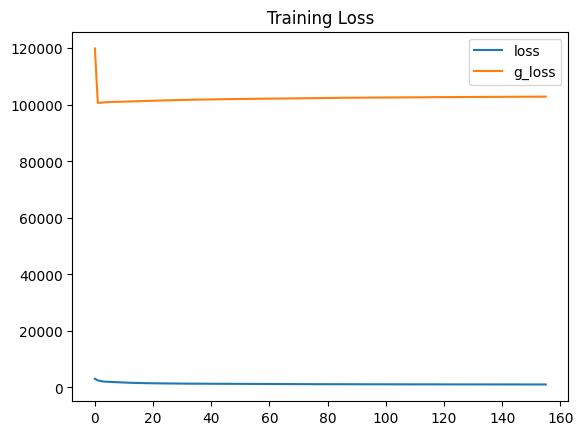

Predicting and Formatting the results.


100%|██████████| 217/217 [00:39<00:00,  5.52it/s]


Evaluating.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 30.7022 29.4991 29.4991
Cyclist AP@0.5: 18.1818 81.3397 81.3397
Car AP@0.7: 52.2470 30.7359 29.1716
==========AOS==========
Pedestrian AOS@0.5: 7.6799 6.9983 6.9983
Cyclist AOS@0.5: 13.3493 27.0798 27.0798
Car AOS@0.7: 59.4928 41.9341 40.8587
==========BBOX_BEV==========
Pedestrian AP@0.5: 55.4113 50.0928 50.0928
Cyclist AP@0.5: 15.9091 52.6316 52.6316
Car AP@0.7: 28.6158 18.9287 17.7876
==========BBOX_3D==========
Pedestrian AP@0.5: 21.6450 19.9443 19.9443
Cyclist AP@0.5: 15.9091 13.3971 13.3971
Car AP@0.7: 10.7691 6.1035 5.6526

==========Overall==========
bbox_2d AP: 33.7104 47.1916 46.6701
AOS AP: 26.8407 25.3374 24.9790
bbox_bev AP: 33.3121 40.5510 40.1706
bbox_3d AP: 16.1077 13.1483 12.9980
==================== 156 ====================


100%|██████████| 1317/1317 [09:23<00:00,  2.34it/s]


==================== 157 ====================


100%|██████████| 1317/1317 [08:56<00:00,  2.46it/s]


==================== 158 ====================


100%|██████████| 1317/1317 [08:55<00:00,  2.46it/s]


==================== 159 ====================


100%|██████████| 1317/1317 [08:56<00:00,  2.46it/s]


==================== 160 ====================


100%|██████████| 1317/1317 [08:53<00:00,  2.47it/s]


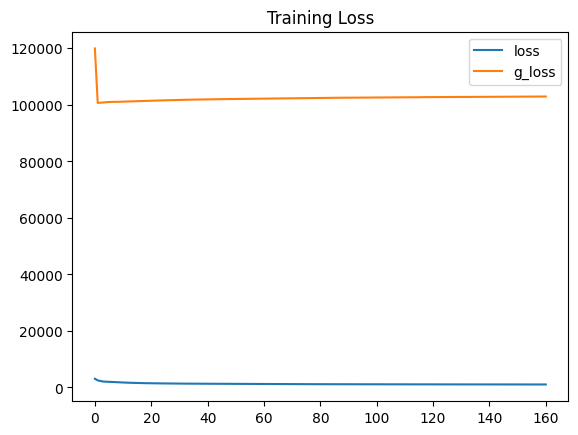

Predicting and Formatting the results.


100%|██████████| 217/217 [00:39<00:00,  5.47it/s]


Evaluating.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 0.0541 0.0928 0.0928
Cyclist AP@0.5: 1.1364 30.8612 30.8612
Car AP@0.7: 12.3479 10.2395 10.0124
==========AOS==========
Pedestrian AOS@0.5: 0.0191 0.0191 0.0191
Cyclist AOS@0.5: 0.0000 5.6336 5.6336
Car AOS@0.7: 16.0369 13.0235 12.7965
==========BBOX_BEV==========
Pedestrian AP@0.5: 0.1082 0.1855 0.1855
Cyclist AP@0.5: 0.0000 11.0048 11.0048
Car AP@0.7: 7.3819 5.5936 5.1575
==========BBOX_3D==========
Pedestrian AP@0.5: 0.0000 0.0000 0.0000
Cyclist AP@0.5: 0.0000 0.1196 0.1196
Car AP@0.7: 0.2595 0.1648 0.1467

==========Overall==========
bbox_2d AP: 4.5128 13.7312 13.6555
AOS AP: 5.3520 6.2254 6.1498
bbox_bev AP: 2.4967 5.5946 5.4493
bbox_3d AP: 0.0865 0.0948 0.0888
==================== 161 ====================


100%|██████████| 1317/1317 [08:55<00:00,  2.46it/s]


==================== 162 ====================


100%|██████████| 1317/1317 [08:52<00:00,  2.47it/s]


==================== 163 ====================


100%|██████████| 1317/1317 [08:54<00:00,  2.46it/s]


==================== 164 ====================


100%|██████████| 1317/1317 [08:53<00:00,  2.47it/s]


==================== 165 ====================


100%|██████████| 1317/1317 [08:52<00:00,  2.47it/s]


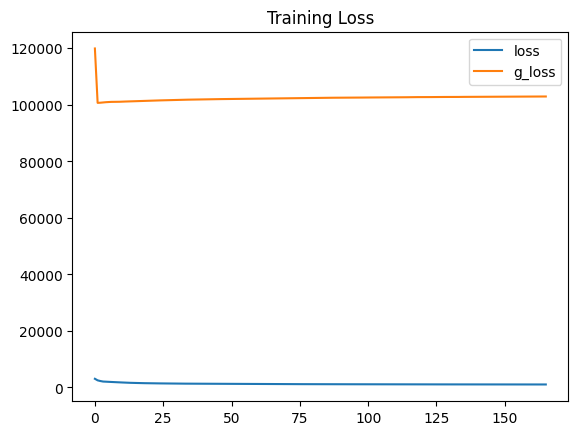

Predicting and Formatting the results.


100%|██████████| 217/217 [00:38<00:00,  5.60it/s]


Evaluating.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 2.1645 2.1336 2.1336
Cyclist AP@0.5: 18.1818 81.3397 81.3397
Car AP@0.7: 59.9291 42.1582 40.2815
==========AOS==========
Pedestrian AOS@0.5: 0.8097 0.8218 0.8218
Cyclist AOS@0.5: 14.2417 25.5338 25.5338
Car AOS@0.7: 66.1695 55.1053 53.6939
==========BBOX_BEV==========
Pedestrian AP@0.5: 38.2576 29.7774 29.7774
Cyclist AP@0.5: 15.9091 50.7177 50.7177
Car AP@0.7: 43.4574 30.7110 28.5741
==========BBOX_3D==========
Pedestrian AP@0.5: 5.3571 5.4267 5.4267
Cyclist AP@0.5: 15.9091 17.3445 17.3445
Car AP@0.7: 13.3663 10.3690 7.0315

==========Overall==========
bbox_2d AP: 26.7585 41.8772 41.2516
AOS AP: 27.0736 27.1536 26.6831
bbox_bev AP: 32.5413 37.0687 36.3564
bbox_3d AP: 11.5442 11.0467 9.9342
==================== 166 ====================


100%|██████████| 1317/1317 [08:51<00:00,  2.48it/s]


==================== 167 ====================


100%|██████████| 1317/1317 [08:54<00:00,  2.46it/s]


==================== 168 ====================


100%|██████████| 1317/1317 [08:51<00:00,  2.48it/s]


==================== 169 ====================


100%|██████████| 1317/1317 [08:52<00:00,  2.47it/s]


==================== 170 ====================


100%|██████████| 1317/1317 [08:53<00:00,  2.47it/s]


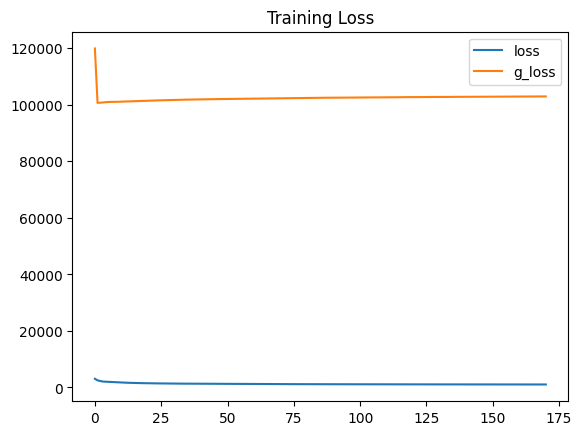

Predicting and Formatting the results.


100%|██████████| 217/217 [00:39<00:00,  5.44it/s]


Evaluating.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 0.3788 0.5102 0.5102
Cyclist AP@0.5: 13.6364 69.9761 69.9761
Car AP@0.7: 20.5105 17.8470 17.9709
==========AOS==========
Pedestrian AOS@0.5: 2.7732 2.7732 2.7732
Cyclist AOS@0.5: 0.6920 26.2198 26.2198
Car AOS@0.7: 23.0053 21.3040 20.9724
==========BBOX_BEV==========
Pedestrian AP@0.5: 49.3506 38.9610 38.9610
Cyclist AP@0.5: 13.6364 53.5885 53.5885
Car AP@0.7: 18.6560 13.0827 12.7264
==========BBOX_3D==========
Pedestrian AP@0.5: 0.3788 0.4174 0.4174
Cyclist AP@0.5: 3.4091 12.4402 12.4402
Car AP@0.7: 1.9327 1.5761 1.5220

==========Overall==========
bbox_2d AP: 11.5086 29.4444 29.4857
AOS AP: 8.8235 16.7657 16.6551
bbox_bev AP: 27.2144 35.2107 35.0920
bbox_3d AP: 1.9069 4.8112 4.7932
==================== 171 ====================


100%|██████████| 1317/1317 [08:52<00:00,  2.48it/s]


==================== 172 ====================


100%|██████████| 1317/1317 [08:54<00:00,  2.46it/s]


==================== 173 ====================


100%|██████████| 1317/1317 [08:53<00:00,  2.47it/s]


==================== 174 ====================


100%|██████████| 1317/1317 [08:52<00:00,  2.47it/s]


==================== 175 ====================


100%|██████████| 1317/1317 [08:50<00:00,  2.48it/s]


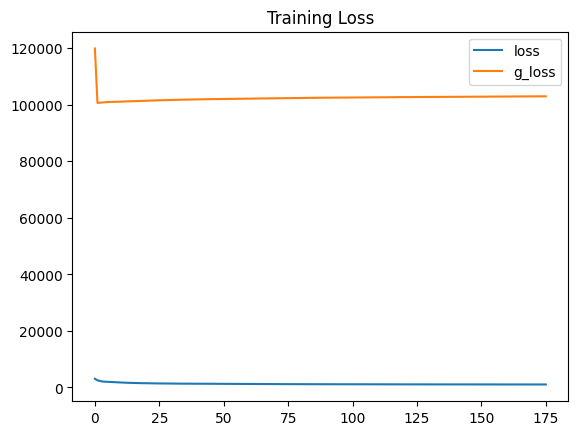

Predicting and Formatting the results.


100%|██████████| 217/217 [00:39<00:00,  5.56it/s]


Evaluating.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 2.4242 2.4242 2.4242
Cyclist AP@0.5: 18.1818 38.5167 38.5167
Car AP@0.7: 10.5429 6.3688 6.1419
==========AOS==========
Pedestrian AOS@0.5: 0.1678 0.1669 0.1669
Cyclist AOS@0.5: 5.5647 7.4280 7.4280
Car AOS@0.7: 9.2271 6.8676 6.9581
==========BBOX_BEV==========
Pedestrian AP@0.5: 30.7022 28.3859 28.3859
Cyclist AP@0.5: 18.1818 41.0287 41.0287
Car AP@0.7: 5.0005 2.7278 2.6040
==========BBOX_3D==========
Pedestrian AP@0.5: 0.0000 0.0928 0.0928
Cyclist AP@0.5: 11.3636 3.1100 3.1100
Car AP@0.7: 0.1611 0.1494 0.1375

==========Overall==========
bbox_2d AP: 10.3830 15.7699 15.6943
AOS AP: 4.9865 4.8208 4.8510
bbox_bev AP: 17.9615 24.0475 24.0062
bbox_3d AP: 3.8416 1.1174 1.1134
==================== 176 ====================


100%|██████████| 1317/1317 [08:51<00:00,  2.48it/s]


==================== 177 ====================


100%|██████████| 1317/1317 [08:50<00:00,  2.48it/s]


==================== 178 ====================


100%|██████████| 1317/1317 [08:49<00:00,  2.49it/s]


==================== 179 ====================


100%|██████████| 1317/1317 [08:51<00:00,  2.48it/s]


==================== 180 ====================


100%|██████████| 1317/1317 [08:50<00:00,  2.48it/s]


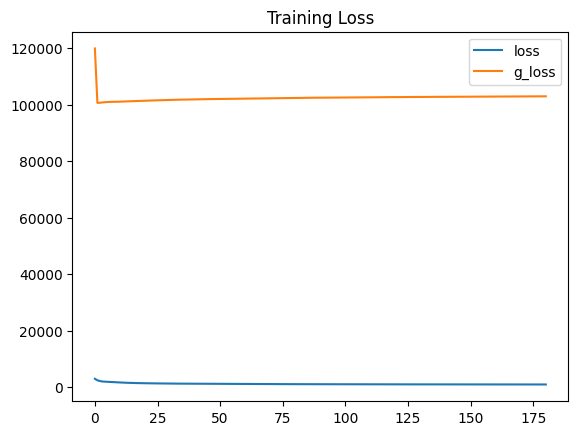

Predicting and Formatting the results.


100%|██████████| 217/217 [00:38<00:00,  5.63it/s]


Evaluating.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 4.8701 5.5659 5.5659
Cyclist AP@0.5: 18.1818 87.3206 87.3206
Car AP@0.7: 51.5898 39.0832 37.6427
==========AOS==========
Pedestrian AOS@0.5: 0.7819 0.6286 0.6286
Cyclist AOS@0.5: 2.1046 39.4097 39.4097
Car AOS@0.7: 56.8065 47.9904 45.1737
==========BBOX_BEV==========
Pedestrian AP@0.5: 18.6688 13.5436 13.5436
Cyclist AP@0.5: 18.1818 67.8230 67.8230
Car AP@0.7: 38.8715 29.9768 28.9919
==========BBOX_3D==========
Pedestrian AP@0.5: 1.7316 1.7625 1.7625
Cyclist AP@0.5: 18.1818 29.4258 29.4258
Car AP@0.7: 6.0188 3.0904 2.8790

==========Overall==========
bbox_2d AP: 24.8806 43.9899 43.5097
AOS AP: 19.8977 29.3429 28.4040
bbox_bev AP: 25.2407 37.1145 36.7862
bbox_3d AP: 8.6441 11.4263 11.3558
==================== 181 ====================


100%|██████████| 1317/1317 [08:49<00:00,  2.49it/s]


==================== 182 ====================


100%|██████████| 1317/1317 [08:52<00:00,  2.47it/s]


==================== 183 ====================


100%|██████████| 1317/1317 [08:51<00:00,  2.48it/s]


==================== 184 ====================


100%|██████████| 1317/1317 [08:50<00:00,  2.48it/s]


==================== 185 ====================


100%|██████████| 1317/1317 [08:49<00:00,  2.49it/s]


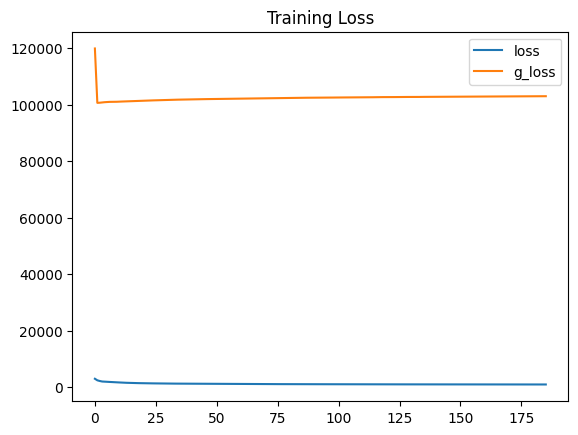

Predicting and Formatting the results.


100%|██████████| 217/217 [00:38<00:00,  5.60it/s]


Evaluating.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 3.1385 2.8757 2.8757
Cyclist AP@0.5: 4.5455 69.9761 69.9761
Car AP@0.7: 29.2591 26.5465 26.2962
==========AOS==========
Pedestrian AOS@0.5: 8.5937 8.6211 8.6211
Cyclist AOS@0.5: 0.0333 17.9088 17.9088
Car AOS@0.7: 38.0286 33.6794 33.2534
==========BBOX_BEV==========
Pedestrian AP@0.5: 0.2706 0.2783 0.2783
Cyclist AP@0.5: 3.4091 52.6316 52.6316
Car AP@0.7: 27.9170 21.3495 20.7904
==========BBOX_3D==========
Pedestrian AP@0.5: 0.0000 0.0000 0.0000
Cyclist AP@0.5: 0.0000 20.3349 20.3349
Car AP@0.7: 0.5548 0.5099 0.4905

==========Overall==========
bbox_2d AP: 12.3144 33.1328 33.0493
AOS AP: 15.5519 20.0698 19.9278
bbox_bev AP: 10.5322 24.7531 24.5667
bbox_3d AP: 0.1849 6.9483 6.9418
==================== 186 ====================


100%|██████████| 1317/1317 [08:53<00:00,  2.47it/s]


==================== 187 ====================


100%|██████████| 1317/1317 [08:51<00:00,  2.48it/s]


==================== 188 ====================


100%|██████████| 1317/1317 [08:51<00:00,  2.48it/s]


==================== 189 ====================


100%|██████████| 1317/1317 [08:50<00:00,  2.48it/s]


==================== 190 ====================


100%|██████████| 1317/1317 [08:52<00:00,  2.48it/s]


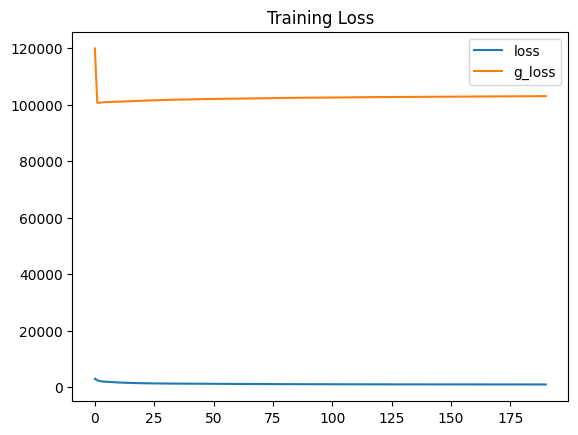

Predicting and Formatting the results.


100%|██████████| 217/217 [00:39<00:00,  5.44it/s]


Evaluating.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 5.0626 5.1484 5.1484
Cyclist AP@0.5: 18.1818 69.9761 69.9761
Car AP@0.7: 69.6014 42.6665 41.0338
==========AOS==========
Pedestrian AOS@0.5: 0.2862 0.2750 0.2750
Cyclist AOS@0.5: 12.0980 20.5547 20.5547
Car AOS@0.7: 75.8120 57.3784 56.2847
==========BBOX_BEV==========
Pedestrian AP@0.5: 42.2972 37.9870 37.9870
Cyclist AP@0.5: 18.1818 53.5885 53.5885
Car AP@0.7: 32.0525 21.4834 20.7324
==========BBOX_3D==========
Pedestrian AP@0.5: 0.1082 0.2783 0.2783
Cyclist AP@0.5: 13.6364 11.4833 11.4833
Car AP@0.7: 10.7636 6.4508 6.1295

==========Overall==========
bbox_2d AP: 30.9486 39.2637 38.7194
AOS AP: 29.3987 26.0694 25.7048
bbox_bev AP: 30.8438 37.6863 37.4360
bbox_3d AP: 8.1694 6.0708 5.9637
==================== 191 ====================


100%|██████████| 1317/1317 [08:53<00:00,  2.47it/s]


==================== 192 ====================


100%|██████████| 1317/1317 [08:51<00:00,  2.48it/s]


==================== 193 ====================


100%|██████████| 1317/1317 [08:52<00:00,  2.47it/s]


==================== 194 ====================


100%|██████████| 1317/1317 [08:54<00:00,  2.47it/s]


==================== 195 ====================


100%|██████████| 1317/1317 [08:52<00:00,  2.47it/s]


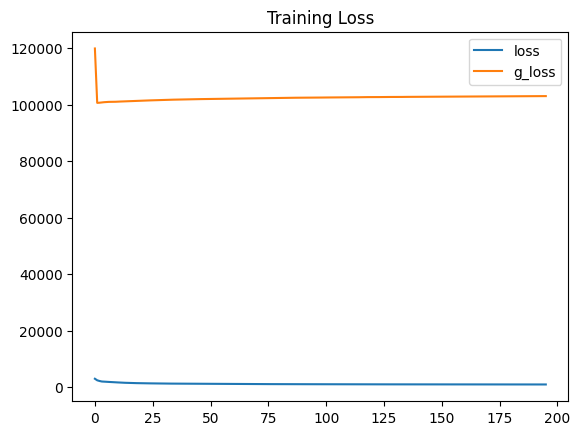

Predicting and Formatting the results.


100%|██████████| 217/217 [00:37<00:00,  5.72it/s]


Evaluating.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 11.4601 10.6294 10.6294
Cyclist AP@0.5: 18.1818 69.9761 69.9761
Car AP@0.7: 45.4257 29.0393 26.9418
==========AOS==========
Pedestrian AOS@0.5: 10.7108 10.3753 10.3753
Cyclist AOS@0.5: 0.0012 19.7815 19.7815
Car AOS@0.7: 53.7821 43.7474 39.8840
==========BBOX_BEV==========
Pedestrian AP@0.5: 39.7727 30.8905 30.8905
Cyclist AP@0.5: 18.1818 30.1435 30.1435
Car AP@0.7: 28.4102 17.2325 12.4518
==========BBOX_3D==========
Pedestrian AP@0.5: 12.3377 11.6883 11.6883
Cyclist AP@0.5: 18.1818 19.1388 19.1388
Car AP@0.7: 5.6426 2.9050 2.6040

==========Overall==========
bbox_2d AP: 25.0225 36.5482 35.8491
AOS AP: 21.4980 24.6347 23.3469
bbox_bev AP: 28.7883 26.0889 24.4953
bbox_3d AP: 12.0540 11.2440 11.1437
==================== 196 ====================


100%|██████████| 1317/1317 [08:55<00:00,  2.46it/s]


==================== 197 ====================


100%|██████████| 1317/1317 [08:54<00:00,  2.46it/s]


==================== 198 ====================


100%|██████████| 1317/1317 [08:54<00:00,  2.47it/s]


==================== 199 ====================


100%|██████████| 1317/1317 [08:55<00:00,  2.46it/s]


In [12]:

epoch0 = 0
global_step=0

for epoch in range(epoch0, args.max_epoch):
# for epoch in range(1):
    epoch_loss0 = 0
    epoch_gLoss0 = 0

    train_indices = np.random.randint(train_dataset_length, size=train_dataset_batch_count)

    print('=' * 20, epoch, '=' * 20)

    train_step, val_step = 0, 0

    pointpillars.train()

    for i, data_dict in enumerate(tqdm(train_dataloader)):
        if not args.no_cuda:
            # move the tensors to the cuda
            for key in data_dict:
                for j, item in enumerate(data_dict[key]):
                    if torch.is_tensor(item):
                        data_dict[key][j] = data_dict[key][j].cuda()
        
        optimizer.zero_grad()

        batched_pts = data_dict['batched_pts']
        batched_gt_bboxes = data_dict['batched_gt_bboxes']
        batched_labels = data_dict['batched_labels']
        batched_difficulty = data_dict['batched_difficulty']


        bbox_cls_pred0, bbox_pred0, bbox_dir_cls_pred0, anchor_target_dict = pointpillars(batched_pts=batched_pts, 
                                    mode='train',
                                    batched_gt_bboxes=batched_gt_bboxes, 
                                    batched_gt_labels=batched_labels)

        
        ################# Full features #################
        bbox_cls_pred0 = bbox_cls_pred0.permute(0, 2, 3, 1).reshape(-1, args.nclasses)
        bbox_pred0 = bbox_pred0.permute(0, 2, 3, 1).reshape(-1, 7)
        bbox_dir_cls_pred0 = bbox_dir_cls_pred0.permute(0, 2, 3, 1).reshape(-1, 2)


        batched_bbox_labels = anchor_target_dict['batched_labels'].reshape(-1)
        batched_label_weights = anchor_target_dict['batched_label_weights'].reshape(-1)
        batched_bbox_reg = anchor_target_dict['batched_bbox_reg'].reshape(-1, 7)
        batched_dir_labels = anchor_target_dict['batched_dir_labels'].reshape(-1)


        
        pos_idx = (batched_bbox_labels >= 0) & (batched_bbox_labels < args.nclasses)

        bbox_pred0 = bbox_pred0[pos_idx]

        batched_bbox_reg = batched_bbox_reg[pos_idx]
        batched_bbox_reg0 = batched_bbox_reg.clone()


        # sin(a - b) = sin(a)*cos(b) - cos(a)*sin(b)
        bbox_pred0[:, -1] = torch.sin(bbox_pred0[:, -1].clone()) * torch.cos(batched_bbox_reg[:, -1].clone())


        batched_bbox_reg0[:, -1] = torch.cos(bbox_pred0[:, -1].clone()) * torch.sin(batched_bbox_reg[:, -1].clone())


        bbox_dir_cls_pred0 = bbox_dir_cls_pred0[pos_idx]


        batched_dir_labels = batched_dir_labels[pos_idx]

        num_cls_pos = (batched_bbox_labels < args.nclasses).sum()

        bbox_cls_pred0 = bbox_cls_pred0[batched_label_weights > 0]


        batched_bbox_labels[batched_bbox_labels < 0] = args.nclasses
        batched_bbox_labels = batched_bbox_labels[batched_label_weights > 0]

        loss_dict0 = loss_func(bbox_cls_pred=bbox_cls_pred0,
                                bbox_pred=bbox_pred0,
                                bbox_dir_cls_pred=bbox_dir_cls_pred0,
                                batched_labels=batched_bbox_labels, 
                                num_cls_pos=num_cls_pos, 
                                batched_bbox_reg=batched_bbox_reg0, 
                                batched_dir_labels=batched_dir_labels)

        loss0 = loss_dict0['total_loss']
        loss1 = regularize(pointpillars)

        gamma = 0.1 * loss0.item()/loss1.detach().cpu()
        loss = loss0  + gamma*loss1
        loss.backward()

        epoch_loss0 = epoch_loss0 + loss0.item()
        epoch_gLoss0 += loss1.detach().cpu()

        # torch.nn.utils.clip_grad_norm_(pointpillars.parameters(), max_norm=35)
        optimizer.step()
        scheduler.step()

    
        train_step += 1

        global_step = 2*train_dataset_batch_count*epoch + train_step

        if global_step==0:
            model_flag=True
        # if global_step % args.log_freq == 0:
        #     save_summary(writer, loss_dict, global_step, 'train', p,
        #                     lr=optimizer.param_groups[0]['lr'], 
        #                     momentum=optimizer.param_groups[0]['betas'][0],
        #                     model=pointpillars, data=data_cuda, flag=model_flag)

    training_loss0.append(epoch_loss0)
    training_gLoss0.append(epoch_gLoss0)

    if epoch % args.ckpt_freq_epoch == 0:

        checkpoint = {
        'epoch': epoch,
        'model_state_dict': pointpillars.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }   
        torch.save(checkpoint, os.path.join(saved_ckpt_path, f'epoch_{epoch+1}.pth.tar'))
    ###################################### Validation ######################################

    if (epoch % args.val_freq_epoch) == 0 and epoch >0:
    # if (epoch % args.val_freq_epoch) == 0:

        plt.figure()
        plt.plot(np.array(training_loss0))
        plt.plot(np.array(training_gLoss0))
        plt.title("Training Loss")
        plt.legend(["loss", "g_loss"])
        plt.show()

        ################################### Validation ###################################
        pointpillars.eval()

        with torch.no_grad():
            format_results = {}
            print('Predicting and Formatting the results.')
            for i, data_dict in enumerate(tqdm(val_dataloader)):
                if not args.no_cuda:
                    # move the tensors to the cuda
                    for key in data_dict:
                        for j, item in enumerate(data_dict[key]):
                            if torch.is_tensor(item):
                                data_dict[key][j] = data_dict[key][j].cuda()
                
                batched_pts = data_dict['batched_pts']
                batched_gt_bboxes = data_dict['batched_gt_bboxes']
                batched_labels = data_dict['batched_labels']
                batched_difficulty = data_dict['batched_difficulty']
                batch_results0  = pointpillars(batched_pts=batched_pts,
                                        mode='val',
                                        batched_gt_bboxes=batched_gt_bboxes, 
                                        batched_gt_labels=batched_labels)

                for j, result in enumerate(batch_results0):
                    format_result = {
                        'name': [],
                        'truncated': [],
                        'occluded': [],
                        'alpha': [],
                        'bbox': [],
                        'dimensions': [],
                        'location': [],
                        'rotation_y': [],
                        'score': []
                    }
                    
                    calib_info = data_dict['batched_calib_info'][j]
                    tr_velo_to_cam = calib_info['Tr_velo_to_cam'].astype(np.float32)
                    r0_rect = calib_info['R0_rect'].astype(np.float32)
                    P2 = calib_info['P2'].astype(np.float32)
                    image_shape = data_dict['batched_img_info'][j]['image_shape']
                    idx = data_dict['batched_img_info'][j]['image_idx']
                    result_filter = keep_bbox_from_image_range(result, tr_velo_to_cam, r0_rect, P2, image_shape)
                    result_filter = keep_bbox_from_lidar_range(result_filter, pcd_limit_range)

                    lidar_bboxes = result_filter['lidar_bboxes']
                    labels, scores = result_filter['labels'], result_filter['scores']
                    bboxes2d, camera_bboxes = result_filter['bboxes2d'], result_filter['camera_bboxes']
                    for lidar_bbox, label, score, bbox2d, camera_bbox in \
                        zip(lidar_bboxes, labels, scores, bboxes2d, camera_bboxes):
                        format_result['name'].append(LABEL2CLASSES[label])
                        format_result['truncated'].append(0.0)
                        format_result['occluded'].append(0)
                        alpha = camera_bbox[6] - np.arctan2(camera_bbox[0], camera_bbox[2])
                        format_result['alpha'].append(alpha)
                        format_result['bbox'].append(bbox2d)
                        format_result['dimensions'].append(camera_bbox[3:6])
                        format_result['location'].append(camera_bbox[:3])
                        format_result['rotation_y'].append(camera_bbox[6])
                        format_result['score'].append(score)
                    
                    write_label(format_result, os.path.join(args.saved_path_exact, f'{idx:06d}.txt'))

                    format_results[idx] = {k:np.array(v) for k, v in format_result.items()}
            
            write_pickle(format_results, os.path.join(args.saved_path, 'results.pkl'))

        print('Evaluating.. Please wait several seconds.')
        do_eval(format_results, val_dataset.data_infos, CLASSES, args.saved_path)
  

In [ ]:

'''
==========BBOX_2D==========
Pedestrian AP@0.5: 12.5541 12.0594 12.0594
Cyclist AP@0.5: 18.1818 67.8230 67.8230
Car AP@0.7: 90.3473 85.0690 82.6321
==========AOS==========
Pedestrian AOS@0.5: 2.2431 1.8547 1.8547
Cyclist AOS@0.5: 0.0884 9.7744 9.7744
Car AOS@0.7: 90.1198 88.3073 86.8500
==========BBOX_BEV==========
Pedestrian AP@0.5: 17.3160 12.9870 12.9870
Cyclist AP@0.5: 18.1818 53.5885 53.5885
Car AP@0.7: 86.9970 81.8544 71.0886
==========BBOX_3D==========
Pedestrian AP@0.5: 11.4719 10.9462 10.9462
Cyclist AP@0.5: 18.1818 28.7081 28.7081
Car AP@0.7: 71.3308 56.4050 53.9020

==========Overall==========
bbox_2d AP: 40.3611 54.9838 54.1715
AOS AP: 30.8171 33.3121 32.8263
bbox_bev AP: 40.8316 49.4766 45.8880
bbox_3d AP: 33.6615 32.0198 31.1854


==========BBOX_2D==========
Pedestrian AP@0.5: 12.3377 11.1317 11.1317
Cyclist AP@0.5: 3.4091 39.3541 39.3541
Car AP@0.7: 71.9899 55.0626 53.1738
==========AOS==========
Pedestrian AOS@0.5: 2.9628 2.4612 2.4612
Cyclist AOS@0.5: 0.0064 2.0339 2.0339
Car AOS@0.7: 74.2191 63.3802 62.0901
==========BBOX_BEV==========
Pedestrian AP@0.5: 10.1732 6.8182 6.8182
Cyclist AP@0.5: 3.4091 11.9617 11.9617
Car AP@0.7: 57.2220 39.6281 37.3518
==========BBOX_3D==========
Pedestrian AP@0.5: 5.1948 3.1540 3.1540
Cyclist AP@0.5: 3.4091 5.7416 5.7416
Car AP@0.7: 39.7968 26.3120 20.4752

==========Overall==========
bbox_2d AP: 29.2456 35.1828 34.5532
AOS AP: 25.7295 22.6251 22.1951
bbox_bev AP: 23.6014 19.4693 18.7106
bbox_3d AP: 16.1336 11.7359 9.7903
'''

'\n==========BBOX_2D==========\nPedestrian AP@0.5: 12.5541 12.0594 12.0594\nCyclist AP@0.5: 18.1818 67.8230 67.8230\nCar AP@0.7: 90.3473 85.0690 82.6321\n==========AOS==========\nPedestrian AOS@0.5: 2.2431 1.8547 1.8547\nCyclist AOS@0.5: 0.0884 9.7744 9.7744\nCar AOS@0.7: 90.1198 88.3073 86.8500\n==========BBOX_BEV==========\nPedestrian AP@0.5: 17.3160 12.9870 12.9870\nCyclist AP@0.5: 18.1818 53.5885 53.5885\nCar AP@0.7: 86.9970 81.8544 71.0886\n==========BBOX_3D==========\nPedestrian AP@0.5: 11.4719 10.9462 10.9462\nCyclist AP@0.5: 18.1818 28.7081 28.7081\nCar AP@0.7: 71.3308 56.4050 53.9020\n\n==========Overall==========\nbbox_2d AP: 40.3611 54.9838 54.1715\nAOS AP: 30.8171 33.3121 32.8263\nbbox_bev AP: 40.8316 49.4766 45.8880\nbbox_3d AP: 33.6615 32.0198 31.1854\n'

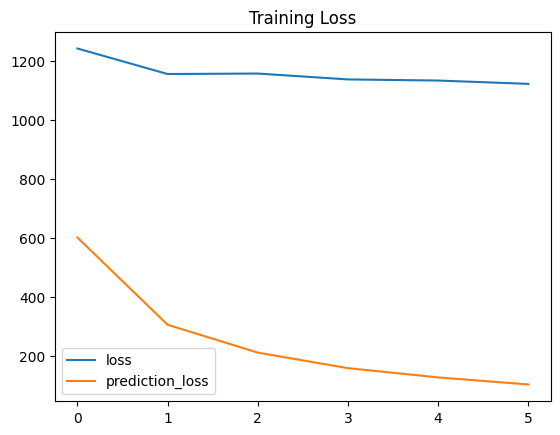

In [ ]:

    #     global_step = epoch * len(train_dataloader) + train_step + 1

    #     if global_step % args.log_freq == 0:
    #         save_summary(writer, loss_dict0, global_step, 'train',
    #                         lr=optimizer.param_groups[0]['lr'], 
    #                         momentum=optimizer.param_groups[0]['betas'][0])
    #     train_step += 1

    # training_loss0.append(epoch_loss0)
    # training_gLoss0.append(epoch_gLoss0.detach().cpu())

    # if epoch % 2 == 0:
    #     continue

    # pointpillars.eval()
    # with torch.no_grad():
    #     for i, data_dict in enumerate(tqdm(val_dataloader)):
    #         try:
    #             if not args.no_cuda:
    #                 # move the tensors to the cuda
    #                 for key in data_dict:
    #                     for j, item in enumerate(data_dict[key]):
    #                         if torch.is_tensor(item):
    #                             data_dict[key][j] = data_dict[key][j].cuda()
                
    #             batched_pts = data_dict['batched_pts']
    #             batched_gt_bboxes = data_dict['batched_gt_bboxes']
    #             batched_labels = data_dict['batched_labels']
    #             batched_difficulty = data_dict['batched_difficulty']

    #             bbox_cls_pred0, bbox_pred0, bbox_dir_cls_pred0, anchor_target_dict, x, xe = pointpillars(batched_pts=batched_pts, 
    #                                         batched_pts0=batched_pts0, 
    #                                         mode='train',
    #                                         batched_gt_bboxes=batched_gt_bboxes, 
    #                                         batched_gt_labels=batched_labels)\
    #                 # bbox_cls_pred1, bbox_pred1, bbox_dir_cls_pred1, \
    #                 #     bbox_cls_pred2, bbox_pred2, bbox_dir_cls_pred2,  = \

                
    #             ################# Full features #################
    #             bbox_cls_pred0 = bbox_cls_pred0.permute(0, 2, 3, 1).reshape(-1, args.nclasses)
    #             bbox_pred0 = bbox_pred0.permute(0, 2, 3, 1).reshape(-1, 7)
    #             bbox_dir_cls_pred0 = bbox_dir_cls_pred0.permute(0, 2, 3, 1).reshape(-1, 2)



    #             batched_bbox_labels = anchor_target_dict['batched_labels'].reshape(-1)
    #             batched_label_weights = anchor_target_dict['batched_label_weights'].reshape(-1)
    #             batched_bbox_reg = anchor_target_dict['batched_bbox_reg'].reshape(-1, 7)
    #             batched_dir_labels = anchor_target_dict['batched_dir_labels'].reshape(-1)


                
    #             pos_idx = (batched_bbox_labels >= 0) & (batched_bbox_labels < args.nclasses)

    #             bbox_pred0 = bbox_pred0[pos_idx]


    #             batched_bbox_reg = batched_bbox_reg[pos_idx]
    #             batched_bbox_reg0 = batched_bbox_reg.clone()

    #             # sin(a - b) = sin(a)*cos(b) - cos(a)*sin(b)
    #             bbox_pred0[:, -1] = torch.sin(bbox_pred0[:, -1].clone()) * torch.cos(batched_bbox_reg[:, -1].clone())
    #             batched_bbox_reg0[:, -1] = torch.cos(bbox_pred0[:, -1].clone()) * torch.sin(batched_bbox_reg[:, -1].clone())
    #             bbox_dir_cls_pred0 = bbox_dir_cls_pred0[pos_idx]
    #             batched_dir_labels = batched_dir_labels[pos_idx]
    #             num_cls_pos = (batched_bbox_labels < args.nclasses).sum()
    #             bbox_cls_pred0 = bbox_cls_pred0[batched_label_weights > 0]


    #             batched_bbox_labels[batched_bbox_labels < 0] = args.nclasses
    #             batched_bbox_labels = batched_bbox_labels[batched_label_weights > 0]

    #             loss_dict0 = loss_func(bbox_cls_pred=bbox_cls_pred0,
    #                                     bbox_pred=bbox_pred0,
    #                                     bbox_dir_cls_pred=bbox_dir_cls_pred0,
    #                                     batched_labels=batched_bbox_labels, 
    #                                     num_cls_pos=num_cls_pos, 
    #                                     batched_bbox_reg=batched_bbox_reg0, 
    #                                     batched_dir_labels=batched_dir_labels)
                
                
    #             loss0 = loss_dict0['total_loss'] 
                
    #             gLoss = torch.norm(x-xe)


    #             if not np.isnan(loss0.item()):
    #                 val_epoch_loss0 = val_epoch_loss0 + loss0.item()
    #                 val_epoch_gLoss0 = val_epoch_gLoss0 + lambda_g*gLoss


    #             else:
    #                 continue

    #             global_step = epoch * len(val_dataloader) + val_step + 1
    #             if global_step % args.log_freq == 0:
    #                 save_summary(writer, loss_dict0, global_step, 'val')
    #             val_step += 1
            
    #         except:
    #             None

    # val_loss0.append(val_epoch_loss0)
    # val_gLoss0.append(val_epoch_gLoss0.detach().cpu())
            
    # pointpillars.train()

    # if (epoch + 1) % args.ckpt_freq_epoch == 0:
    #     torch.save(pointpillars.state_dict(), os.path.join(saved_ckpt_path, f'epoch_{epoch+1}.pth'))
    #     checkpoint = {
    #     'epoch': epoch,
    #     'model_state_dict': pointpillars.state_dict(),
    #     'optimizer_state_dict': optimizer.state_dict(),
    #     'loss': loss
    #     }   
    #     torch.save(checkpoint, os.path.join(saved_ckpt_path, f'epoch_{epoch+1}.pth.tar'))
    #     np.save(os.path.join(saved_ckpt_path, f'train_loss.npy'), np.array(training_loss0))
    #     np.save(os.path.join(saved_ckpt_path, f'train_gloss.npy'), np.array(training_gLoss0))
    #     np.save(os.path.join(saved_ckpt_path, f'val_loss.npy'), np.array(val_loss0))
    #     np.save(os.path.join(saved_ckpt_path, f'val_gloss.npy'), np.array(val_gLoss0))

    # if (epoch + 1) % args.plot_freq_epoch == 0:

plt.figure()
plt.plot(np.array(training_loss0))
plt.plot(np.array(training_gLoss0)*0.01)
plt.title("Training Loss")
plt.legend(["loss", "g_loss"])
plt.show()

    #     plt.figure()
    #     plt.plot(np.array(val_loss0))
    #     plt.plot(np.array(val_gLoss0))
    #     plt.title("Validation Loss")
    #     plt.legend(["loss","prediction_loss"])
    #     plt.show()